# **INTRO**

Welcome to the third notebook of my project on time series analysis of UK energy generation data from National Grid ESO.

In a continuation of the linear regression modelling I conducted in my second notebook (Advanced EDA & Initial Modelling), I will run <a href="https://drive.google.com/file/d/1-6S5tTm_gDQ-jMa8kOKDjtOe1W6Keabz/view?usp=drive_link">data</a> from the <a href= "https://www.nationalgrideso.com/data-portal/historic-generation-mix/historic_gb_generation_mix">National Grid ESO</a> through the below models:

- XGBoost 

- SARIMA

- SARIMAX

I will then use the best-performing model to forecast future values of energy generation. The ultimate question we are hoping to answe is, "Will the UK have the renewable energy generation capacity to meet the country's energy needs and achieve net zero by 2050?"

Since the official wording from the <a href="https://commonslibrary.parliament.uk/research-briefings/cbp-9888/">House of Commons Library</a> is, "The UK is committed to reaching net zero by 2050", I am assuming that net zero obligations should be met prior to 2050, and will use December 2049 as the last month for my predicted values.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from tempfile import mkdtemp
cachdir = mkdtemp()
import pickle

In [3]:
import warnings #suppress future warnings messages for better readability
warnings.simplefilter(action='ignore', category=FutureWarning)

There will be several figures/plots in this notebook. In order to save time and avoid having to set the parameters for each plot, let's define the default font sizes for all the plots.

In [4]:
#set default font sizes
small_size = 13
medium_size = 15
large_size = 17

#change the font size for individual elements
mpl.rc("font", size=small_size)  # controls default text sizes
mpl.rc("axes", titlesize=small_size)  # fontsize of the axes title
mpl.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
mpl.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
mpl.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
mpl.rc("legend", fontsize=small_size)  # legend fontsize
mpl.rc("axes", titlesize=large_size)  # title fontsize

In [5]:
#loading in the cleaned data and re-indexing using the DATETIME column
generation = pd.read_csv('data/natl_grid_eso_generation_2009_to_2024feb_clean.csv', parse_dates=['DATETIME'], index_col='DATETIME')

In [6]:
#create dataframe where each row is a monthly sum for that column
g_monthly = generation[['GAS', 'COAL', 'NUCLEAR', 'WIND', 'HYDRO', 'IMPORTS', 'BIOMASS',
                        'SOLAR', 'STORAGE', 'GENERATION', 'RENEWABLE', 'FOSSIL']].resample('MS').sum()
g_monthly

,GAS,COAL,NUCLEAR,WIND,HYDRO,IMPORTS,BIOMASS,SOLAR,STORAGE,GENERATION,RENEWABLE,FOSSIL
DATETIME,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,22765366.0,30849365.0,8623216.0,862478.0,811042.0,882060.0,0.0,0.0,682214.0,65475735.0,1673513.0,53614734.0
2009-02-01 00:00:00+00:00,19651944.0,25219773.0,10836805.0,564923.0,542855.0,831729.0,0.0,0.0,675286.0,58323292.0,1107790.0,44871717.0
2009-03-01 00:00:00+00:00,22881351.0,19929200.0,12675530.0,954612.0,861294.0,1025856.0,0.0,0.0,626558.0,58954386.0,1815914.0,42810548.0
2009-04-01 00:00:00+00:00,22166365.0,13295828.0,12074650.0,634044.0,558552.0,1898691.0,0.0,0.0,439888.0,51068026.0,1192588.0,35462199.0
2009-05-01 00:00:00+00:00,23179257.0,12618719.0,10158450.0,812647.0,459668.0,2600090.0,0.0,0.0,573244.0,50402036.0,1272293.0,35797976.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01 00:00:00+00:00,12338224.0,726000.0,6371257.0,15316055.0,882318.0,5029141.0,2778050.0,1601574.0,323464.0,45865315.0,17799950.0,13064222.0
2023-11-01 00:00:00+00:00,15201270.0,1158663.0,5672885.0,14990727.0,676988.0,5981536.0,3403161.0,938528.0,334804.0,48858943.0,16606238.0,16359933.0
2023-12-01 00:00:00+00:00,13114424.0,605932.0,7237706.0,20745933.0,779497.0,4316784.0,2993227.0,414101.0,463434.0,51229568.0,21939533.0,13720353.0


>> Note on a change to the g_monthly dataframe: the creation of the dataframe has changed from **.mean()** in the AdvancedEDA notebook to **.sum()** in this notebook. Each row will now calculate the **TOTAL** energy generation each month. Previously, the use of .mean() calculated the average energy generation of any given half-hour block of time in that month. While the different calculation is unlikely to have affected the accuracy of the Linear Regression model that was run in the notebook (ie, the underlying data didn't change), it will be easier to use forecasted values if the dataframe calculated total generation rather than mean generation (ie, each forecasted averaged half-hour value would otherwise need to be multiplied by 48 half-hours per day and 30 days per month to get total monthly energy generation). 

### MODELLING METRICS

The linear regression model from the Advanced EDA notebook had an accuracy score of 70% (for both the Train and Test sets), with the below metrics:


**R2 score (Test):** 71%

**RMSE score (Test - abs):** 1570.53

**RMSE score (Test - %):** 5.0%

**MAPE (Test):** 4.1%


Moving forward, MAPE and RMSE will be used as our model metrics. Since RMSE returns a value (the squared difference between the actual values and predicted values), it is scale-dependent. In contrast, MAPE returns the error as a percentage, which is more flexible against data with a wide range (ie, close-to-zero generation values for sources like Storage and Battery, vs higher energy generation sources like Wind and Gas). 


Before starting modelling, let's create a function to automate modelling metrics using the same two metrics previously used to evaluate our linear regression model (ie, MAPE and RMSE) in the Advanced EDA notebook. 

>> Note: The documentation for MAPE states, "Note here that the output is not a percentage in the range [0, 100] and a value of 100 does not mean 100%" (ie, the results are scaled to 1, not 100, and would need to be multiplied by 100 to get the percentage). As such, we will first define our own MAPE function, and then use that within the model evaluation function.

In [7]:
#MAPE function
def mean_absolute_percentage_error(y_train, y_pred):
    y_train, y_pred = np.array(y_train), np.array(y_pred)
    return np.mean(np.abs((y_train - y_pred) / y_train))*100

#if using mean_absolute_percentage_error function from sklearn.metrics, replace the two calculations in the function with the below:
#print(f'Model {i} Train MAPE: {round(train_mape*100,2)}%')
#print(f'Model {i} Test MAPE: {round(test_mape*100,2)}%')

In [8]:
def evaluate_sarimax(fitted_model_list,  X_train, y_train, y_test, future_exog, steps_test, train_mean):

    """
    Evaluates the SARIMAX model's performance by calculating the MAPE and RMSE for both training and test sets for a list of models with adjusted parameters

    INPUTS:
    fitted_model_list: list of fitted SARIMAX models to evaluate
    X_train: training dataset feature
    y_train: training dataset target variable
    y_test: test dataset target variable
    future_exog: exogenous variable for future predictions (should match the length of steps_test)
    steps_test: number of steps to forecast for the test set
    train_mean: mean of the target values from the training dataset

    OUTPUTS:
    A tuple containing four lists with the following evaluation metrics for each model:
    - train_mape_results: Mean Absolute Percentage Error for the training set
    - test_mape_results: Mean Absolute Percentage Error for the test set
    - train_rmse_results (abs): Root Mean Squared Error for the training set (absolute number)
    - train_rmse_results (%): Root Mean Squared Error for the training set (percentage)
    - test_rmse_results (abs): Root Mean Squared Error for the test set (absolute number)
    - test_rmse_results (%): Root Mean Squared Error for the test set (percentage)
    """

    train_mape_results = []
    test_mape_results = []
    
    train_rmse_results = []
    test_rmse_results = []
    
    #forecasts
    for i, model in enumerate(fitted_model_list, start=1):
        forecast = model.forecast(steps=steps_test, exog=future_exog[:steps_test])
        backcast = model.predict(start=0, end=len(X_train)-1)

        #calculate MAPE
        train_mape = mean_absolute_percentage_error(y_train, backcast)
        train_mape_results.append(train_mape)
        print(f'Model {i} Train MAPE: {round(train_mape,2)}%')

        test_mape = mean_absolute_percentage_error(y_test, forecast[:len(y_test)])
        test_mape_results.append(test_mape)
        print(f'Model {i} Test MAPE: {round(test_mape,2)}%')

        #calculate RMSE
        train_mse = mean_squared_error(y_train, backcast)
        train_rmse = np.sqrt(train_mse)
        train_rmse_results.append(train_rmse)
        
        test_mse = mean_squared_error(y_test, forecast[:len(y_test)])
        test_rmse = np.sqrt(test_mse)
        test_rmse_results.append(test_rmse)

        print(f'Model {i} Train RMSE (abs): {train_rmse}')
        print(f'Model {i} Train RMSE (%): {round((train_rmse / train_mean),2)*100}%')

        print(f'Model {i} Test RMSE (abs): {test_rmse}')
        print(f'Model {i} Test RMSE (%): {round((test_rmse / train_mean),2)*100}%')
    
    return train_mape_results, test_mape_results, train_rmse_results, test_rmse_results

#### Summary of Advance EDA and Initial Modelling notebook

Next, we'll re-run the code from the previous notebook (Advanced EDA and Initial Modelling) to set up the Train and Test sets again for the GENERATION column.

In [9]:
#finding the first and last timestamps in the dataset
min_date = g_monthly.index.min()
max_date = g_monthly.index.max()

#delineating the cutoff date for the Train/Test split
train_percent = 0.75
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between

#create the train and test dataframes
y = g_monthly['GENERATION']
X = g_monthly['GENERATION'].shift(1)
X.dropna(inplace=True) #due to the lag, the first value will be NaN, and thus needs to be dropped
y = y.iloc[1:]

X_train = X[X.index <= train_cutoff]
X_test = X[X.index > train_cutoff]

y_train = y[y.index <= train_cutoff]
y_test = y[y.index > train_cutoff]

Now we're ready to continue modelling. The next model we'll use is the XGBoost model.

### **XGBOOST**

Boosting trains a model sequentially using ensemble learning, where multiple weak models are fitted to a sample of data, then trained sequentially. Each successive model tries to compensate for the weakness of its predecessor, which helps to minimise the loss function and generally results in better performance of the model. 

In "gradient" boosting (the "G" in XGBoost), the target are pseudo-residuals (ie, the representation of the gap between the current model's prediction and the true target), rather than residuals in the traditional sense. This helps with correction against over-specialising (ie, overfitting) on the training data.

The "X" in XGBoost refers to "eXtreme" gradient boosting, and implements both L1  (Lasso) and L2 (Ridge) regularization methods to minimize coefficients to zero. This allows for avoidance of overfitting better than gradient boosting. XGBoost also has built-in cross-validation, ie, the data is split systematically during several iterations.

>> Note on cross-validation: due to the sequential nature of time series, training data cannot be split at random (ie, the data must be split sequentially, as a date chosen at random for the Training set from the future cannot be used to predict results for a date chosen at random from the past in the Test set). While our Train/Test split for the Linear Regression model accounted for the sequential nature of the data, we'll need to also ensure that the Train/Validation sets within the cross validation are also chronologically dependent. To do this, we will use TimeSeriesSplit from SKlearn for creating the splits in the folds of our cross validation. 

>>Additionally, although it is common to use 5 folds in cross validation (ie, 20% of the dataset is set aside as the Test set), we will use 3 folds in our modelling. Due to the chronological nature of TimeSeriesSplit, it makes sense that the Test set include data prior to 2020 and the global Covid pandemic to see the performance of the model on unseen data from both before and after the pandemic. Since there are 15 years of data in the dataset, using 3 folds would mean the last fold begins in 2019, and not in 2021. In addition to changes in energy consumption patterns during the pandemic, it was also noted in the Advanced EDA notebook that the UK experienced some unusual weather patterns in 2020--including the sunniest April in over a century. 

In [10]:
#create placeholders for steps in the pipeline

estimators = [('scaler', StandardScaler()),
              ('model', XGBRegressor())]

pipe = Pipeline(estimators, memory = cachdir, verbose=True)

In [11]:
#structure of parameter grid from Jeremy's Hyperparameter Optimization kickoff notebook

# Parameter grid
params = [
    
    # PcA not necessary; Scaler can be trialled, between Population and Generation
    {'scaler': [None, StandardScaler(), RobustScaler()],
     'model': [XGBRegressor(random_state=42)],
    'model__max_depth': [1, 2, 3, 4, 5], 
    'model__lambda': [0, 0.1, 0.001, 0.0001, 0.00001],
    'model__alpha': [0, 0.1, 0.001, 0.0001, 0.00001]}
]

In [12]:
#chronologically-dependent Train/Test split
my_cv = TimeSeriesSplit(n_splits=3).split(X_train)

#select in refit which of the two scores to use for fitting the best model
grid = GridSearchCV(pipe, params, cv=my_cv)

#the first time running the GridSearchCV, over 60% of the tests failed ("1250 fits failed out of a total of 1875."), as it was expecting a 2D array and X_train is a 1D array
#to fix the issue, we added a new axis to X_train
fittedgrid = grid.fit(X_train.to_numpy()[:,np.newaxis], y_train.to_numpy())

print(fittedgrid.best_params_, fittedgrid.best_score_)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipel

The fitted grid's best_score (ie, the R2 score, which is the default metric) is 33.8%, which is very poor performance. (Pure random chance is 50%, meaning the model performed worse than random chance.) However, this is not entirely unexpected, as the XGBregressor does not account for the time dependence, trends, or seasonality which are inherent in time series analysis. In order to account for the temporal dynamics in time series analysis, we must engineer features that capture those components; ie, we can use feature engineering to create additional lag features (ie, lagging by 2 months, 3 months, and 12 months).

Although the additional features will have strong multicollinearity, that is something XGBregressor inherently handles well. XGBoost has a tree structure which searches for the best split at each step of the tree construction, meaning redundant features (ie, multiple lagged time features) won't be chosen in successive splits if they offer no additional value. Additionally, XGBoost incorporates L1 and L2 regularization techniques, which will reduce overfitting by penalizing large coefficients (similar to how we manually adjusted against large coefficients in the SARIMA/SARIMAX models) and complex models (although complexity is not an issue with time series, as we model single features). 

In [13]:
#create the train and test dataframes
#since this X will have different values to the original X in the Train/Test split, we will assign new variable names
y2 = g_monthly['GENERATION']
X2_1 = g_monthly['GENERATION'].shift(1)
X2_2 = g_monthly['GENERATION'].shift(2)
X2_3 = g_monthly['GENERATION'].shift(3)
X2_12 = g_monthly['GENERATION'].shift(12)

X2 = pd.concat([X2_1, X2_2, X2_3, X2_12], axis=1)

X2.dropna(inplace=True) #due to the lag, the first value will be NaN, and thus needs to be dropped
y2 = y.loc[X2.index] #since we are dropping multiple rows, match Y3 back to X3

X2_train = X2[X2.index <= train_cutoff]
X2_test = X2[X2.index > train_cutoff]

y2_train = y2[y2.index <= train_cutoff]
y2_test = y2[y2.index > train_cutoff]

#chronologically-dependent Train/Test split
my_cv2 = TimeSeriesSplit(n_splits=3).split(X2_train)

In [14]:
grid = GridSearchCV(pipe, params, cv=my_cv2)

fittedgrid2 = grid.fit(X2_train.to_numpy(), y2_train.to_numpy())

print(fittedgrid2.best_params_, fittedgrid2.best_score_)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipel

The R2 score improved to 75.5%. Let's run the model again with adjusted hyperparameters. We will pick values that are in a smaller range and closer to the optimised hyperparameters from our first params definition below. We will not change the max_depth as the minimum is 1, and we will not change the list of scalers.

model__alpha': 0,

'model__lambda': 0.001, 

'model__max_depth': 5, 

'scaler': None

In [15]:
#create placeholders for steps in the pipeline

estimators = [('scaler', StandardScaler()),
              ('model', XGBRegressor())]

pipe = Pipeline(estimators, memory = cachdir, verbose=True)

#chronologically-dependent Train/Test split
my_cv2 = TimeSeriesSplit(n_splits=3).split(X2_train)

params2 = [
    
    # PcA not necessary; Scaler can be trialled, between Population and Generation
    {'scaler': [None, StandardScaler(), RobustScaler()],
     'model': [XGBRegressor(random_state=42)],
    'model__max_depth': [4, 5, 6, 7], 
    'model__lambda': [0.0005, 0.001, 0.005, 0.01],
    'model__alpha': [0, 0.001, 0.01, 0.05]}
]

In [16]:
grid = GridSearchCV(pipe, params2, cv=my_cv2)

fittedgrid3 = grid.fit(X2_train.to_numpy(), y2_train.to_numpy())

print(fittedgrid3.best_params_, fittedgrid3.best_score_)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s


[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipel

The R2 score has improved by 0.5% to 76%. Since each of the best parameters now sit within the adjusted range of hyperparameters (ie, none of them are the inner or outer edge values), we will keep this model as our best-performing model on which to calculate metrics.

In [17]:
gen_mean = g_monthly['GENERATION'].mean()


y_xg3_train = fittedgrid3.best_estimator_.predict(X2_train)
gen_train_rmse = np.sqrt(mean_squared_error(y2_train, y_xg3_train))
print(f'Model Train RMSE (%): {round((gen_train_rmse / gen_mean),2)*100}%')

y_xg3_test = fittedgrid3.best_estimator_.predict(X2_test)
gen_test_rmse = np.sqrt(mean_squared_error(y2_test, y_xg3_test))
print(f'Model Test RMSE (%): {round((gen_test_rmse / gen_mean),2)*100}%')


#calculate MAPE
xgb_train_mape = mean_absolute_percentage_error(y2_train, y_xg3_train)
print(f'Model Train MAPE: {round(xgb_train_mape,2)}%')

xgb_test_mape = mean_absolute_percentage_error(y2_test, y_xg3_test)
print(f'Model Test MAPE: {round(xgb_test_mape,2)}%')

Model Train RMSE (%): 0.0%
Model Test RMSE (%): 5.0%
Model Train MAPE: 0.0%
Model Test MAPE: 4.5%


The model is overfitted on the training set, as the RMSE and MAPE are 0% (ie, 0% margin of error). One possible reason reason for this is the necessity of using the Time_Series_Split. With non-time-dependent data, the Train/Test split and cross-validation allow for more even shuffling of data, thereby lowering the risk of the validation set having lower variance than the Training and Test sets. Even distribution of variance is more difficult to control in time series analysis.

This is in addition to one of the weaknesses of XGBoost as a model, which is its lack of interpretability. As it's a black-box model, it is difficult to understand the underlying factors for its predictions. Another difficulty is that it doesn't inherently support exogenous factors.

Regarding Test metrics, the Test RMSE and Test MAPE look more reasonable, at 5% and 4.5%, which are similar to the metrics seen in the Linear Regression Model. 

Another weakness of XGBoost is that it doesn't have a .forecast() method. Given the starting point of a forecast (ie, the last timestamp in the existing dataset), XGBoost forecasts values one at a time, using the previous value to predict the next future value. While this is similar to the .forecast() method in the SARIMA/SARIMAX model, the main difference is the compounding of errors. Since the SARIMA/SARIMAX model extracts the seasonality and time trend components, the forecasted values only compound errors from the remaining residuals, whereas XGBoost compounds errors from the dataset as a whole.


To have better interpretability of results, and for ease of forecasting, we will move onto using the SARIMA/SARIMAX model next.

### **SARIMA/SARIMAX modelling**

#### SARIMA Model

The SARIMA model was designed to capture the trend and seasonal patterns in time series data. Compared to Linear Regression and XGBoost, the SARIMA (Seasonal AutoRegressive Integrated Moving Average) model has several advantages:

1) seasonality: as the "S" in SARIMA implies, the model explicitly captures the seasonal component in the data. Given the strong seasonal pattern seen in the decomposition plot in the Advanced EDA notebook, it is important this be captured in our modelling. Moreover, extracting the seasonal component helps reduce errors in predicted values (ie, the forecasted values reflect the remaining errors in the residuals, rather than the data as a whole).

2) incorporating autocorrelation: the SARIMA model captures the inherent time dependence in data which linear regression may not effectively capture (ie, the degree of similarity between a time series and a lagged version of itself). The "AR", or autoregressive, modelling approach in SARIMA enables prediction of future behaviour based on past behaviour through using observations of previous time steps as input to predict the next time step

3) differencing: the letter "I" in SARIMA denotes "Integration", or "differencing", a transformation which can help reduce or remove trend and seasonality, making a non-stationary series stationary (thereby allowing us to model with non-stationary data).

4) incorporating moving average terms: the "MA" component of the SARIMA model allows for incorporating previous time points in a weighted manner, which can help capture short-term flucturations in the data.

As a reminder, we had decided on an initial set of hyperparameters in the Advanced EDA notebook for use in modelling after plotting ACF and PACF:

p=3

d=1

q=2


s=12

P = 1

D = 1

Q = 1

We will now take the hyperparameters and input them into a SARIMA model.

In [18]:
#set hyperparameters
p = 3
d = 1
q = 2

s = 12

P = 1
D = 1
Q = 1


#instantiate
sarima = SARIMAX(X_train, order=(p, d, q), seasonal_order=(P, D, Q, s))

#fit
y_train_fit = sarima.fit(disp=0)

y_train_fit.summary()

/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           GENERATION   No. Observations:                  135
Model:             SARIMAX(3, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1966.967
Date:                              Mon, 15 Apr 2024   AIC                           3949.935
Time:                                      15:15:23   BIC                           3972.367
Sample:                                  02-01-2009   HQIC                          3959.046
                                       - 04-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0382      0.034     -1.109      0.267      -0.106       0.029
ar.L2          0.9119      0.041     22.244      0.000       0.832       0.992
ar.L3          0.0578      0.019      3.022      0.003       0.020       0.095
ma.L1          0.0013      0.485      0.003      0.998      -0.950       0.952
ma.L2         -0.9987      0.083    -12.083      0.000      -1.161      -0.837
ar.S.L12      -0.4345      0.487     -0.892      0.372      -1.389       0.520
ma.S.L12       0.4816      0.468      1.029      0.303      -0.435       1.398
sigma2      4.642e+12   1.02e-13   4.53e+25      0.000    4.64e+12    4.64e+12
===================================================================================
Ljung-Box (L1) (Q):                  15.92   Jarque-Bera (JB):                30.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.40
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.93e+41. Standard errors may be unstable.
"""

Looking at the results, we can see from the coefficients that there is room to adjust our model. Ideally, the p-values should all be statistically significant (ie, the p-values for ar.L1, ma.L1, ar.S.L12, and ma.S.L12 should be closer to zero). It's interesting that ar.L1 and ma.L1 have p-values above 0.05 while the p-values for ar.L2 and ma.L2 are 0, as all four values correlate to the non-seasonal hyperparameters (ie, p and q). To better confirm the significance of those hyperparameters, we can run the model again with small p adjusted from 3 to 2.

>>*Note: Since we will adjust multiple parameters, there is the option of using GridSearchCV. However, since GridSearchCV returns a best score based on lowest AIC, it might not return the best fit parameters as it doesn't focus on lowest (ie, statistically significant) p-values. A low p-value indicates the associated hyperparameters are strong predictors for the model. As such, we will adjust the hyperparameters manually, one at a time, to better track the change in hyperparameter to the change in p-values.*

In [19]:
#set hyperparameter p to 2 (from 3)
p = 2
d = 1
q = 2

s = 12

P = 1
D = 1
Q = 1


#instantiate
sarima2 = SARIMAX(X_train, order=(p, d, q), seasonal_order=(P, D, Q, s))

#fit
y_train_fit2 = sarima2.fit(disp=0)

y_train_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           GENERATION   No. Observations:                  135
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1968.316
Date:                              Mon, 15 Apr 2024   AIC                           3950.631
Time:                                      15:15:26   BIC                           3970.259
Sample:                                  02-01-2009   HQIC                          3958.604
                                       - 04-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0439      0.382     -2.734      0.006      -1.792      -0.295
ar.L2         -0.5928      0.362     -1.638      0.101      -1.302       0.117
ma.L1          0.9956      0.395      2.524      0.012       0.222       1.769
ma.L2          0.5326      0.386      1.381      0.167      -0.223       1.288
ar.S.L12      -0.4805      0.409     -1.175      0.240      -1.282       0.321
ma.S.L12       0.5170      0.395      1.308      0.191      -0.258       1.292
sigma2      4.865e+12      2e-13   2.43e+25      0.000    4.86e+12    4.86e+12
===================================================================================
Ljung-Box (L1) (Q):                  14.59   Jarque-Bera (JB):                26.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.36
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.99e+41. Standard errors may be unstable.
"""

The p-values for the first several coefficients are now lower, with the two highest remaining coefficients being ma.L2 and ar.S.L12 (0.16 and 0.24). The coefficient ma.L2 is associated with small q, the number of moving average terms. Let's adjust small q next, from 2 to 1.

In [20]:
#set hyperparameters
p = 2
d = 1
q = 1

s = 12

P = 1
D = 1
Q = 1


#instantiate
sarima3 = SARIMAX(X_train, order=(p, d, q), seasonal_order=(P, D, Q, s))

#fit
y_train_fit3 = sarima3.fit(disp=0)

y_train_fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         GENERATION   No. Observations:                  135
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1968.135
Date:                            Mon, 15 Apr 2024   AIC                           3948.270
Time:                                    15:15:28   BIC                           3965.094
Sample:                                02-01-2009   HQIC                          3955.104
                                     - 04-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7269      0.641     -1.134      0.257      -1.983       0.530
ar.L2         -0.0729      0.041     -1.758      0.079      -0.154       0.008
ma.L1          0.6692      0.649      1.031      0.302      -0.603       1.941
ar.S.L12      -0.4751      0.437     -1.087      0.277      -1.332       0.382
ma.S.L12       0.5108      0.424      1.206      0.228      -0.319       1.341
sigma2      5.085e+12   1.89e-13   2.69e+25      0.000    5.09e+12    5.09e+12
===================================================================================
Ljung-Box (L1) (Q):                  14.14   Jarque-Bera (JB):                28.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.37
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.56e+41. Standard errors may be unstable.
"""

Hmmmm......that didn't seem to work, as now ma.L1 is higher. Let's change small q back to 2 and try adjusting large P, instead, as that is associated with the seasonal lag component of the model. (ie, change it from 1 to 2) 

Recall from the PACF plot in the Advanced EDA notebook that there was still some negative autocorrelation at month 12. The large P hyperparameter denotes the number of seasonal autoregressive terms.

In [21]:
#set hyperparameters
p = 2
d = 1
q = 2

s = 12

P = 2
D = 1
Q = 1


#instantiate
sarima4 = SARIMAX(X_train, order=(p, d, q), seasonal_order=(P, D, Q, s))

#fit
y_train_fit4 = sarima4.fit(disp=0)

y_train_fit4.summary()

/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           GENERATION   No. Observations:                  135
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 12)   Log Likelihood               -1951.912
Date:                              Mon, 15 Apr 2024   AIC                           3919.823
Time:                                      15:15:32   BIC                           3942.256
Sample:                                  02-01-2009   HQIC                          3928.935
                                       - 04-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4595      0.053    -27.739      0.000      -1.563      -1.356
ar.L2         -0.9539      0.048    -20.072      0.000      -1.047      -0.861
ma.L1          1.4679      0.061     24.118      0.000       1.349       1.587
ma.L2          0.9469      0.060     15.837      0.000       0.830       1.064
ar.S.L12       0.5638      0.160      3.522      0.000       0.250       0.878
ar.S.L24      -0.1639      0.050     -3.310      0.001      -0.261      -0.067
ma.S.L12      -0.7247      0.184     -3.937      0.000      -1.085      -0.364
sigma2      4.865e+12   4.55e-15   1.07e+27      0.000    4.86e+12    4.86e+12
===================================================================================
Ljung-Box (L1) (Q):                  12.80   Jarque-Bera (JB):                 9.82
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.62   Skew:                             0.15
Prob(H) (two-sided):                  0.13   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.66e+43. Standard errors may be unstable.
"""

The p-values of the coefficients are now all at zero or very close to zero. Next, we will add an exogenous variable to our model. Exogenous variables are predictors from external datasets, and are what add the "X" to the SARIMAX model.

### SARIMAX: exogenous variable

From EDA and Advanced EDA, we saw a general downward trend in total energy generation over the past 15 years. Rationally speaking, it is unlikely the downward trend will continue indefinitely into the future, for several reasons, including:

1) forecasted <a href="https://stats.oecd.org/index.aspx?DataSetCode=POP_PROJ#">population growth</a>  (and not decline) for the UK over the next several decades

2) the downward trend may be skewed by the energy mix of various energy sources in the data. As the UK moves away from fossil fuels, the amount of gas and coal energy generated is declining, while the amount of wind and other renewable energy sources is growing. It is important to account for different trends in our modelling, in order to reach more accurate forecaste of total future energy generation. As such, it makes sense to model the energy sources separately (which we will do later on).

Regarding the first point, we will add population growth as an exogenous factor in our SARIMA model, making it a SARIMAX model. We'll need to add population as a new column in the dataframe and call it as a parameter (ie, "exog=").

The first step in doing this is finding the appropriate external dataset. We can download historical population data from the OECD website <a href="https://stats.oecd.org/index.aspx?DataSetCode=POP_PROJ#">here</a>, with the following filters:

Country: United Kingdom

Sex: All persons

Age: Population (hist&proj) All ages

Time: 2009 to 2050

(.csv of downloaded data also available <a href="https://drive.google.com/file/d/1V_bW197bNmRze6QR1mHGIfaboooo4_yv/view?usp=drive_link">here</a>)

Next, we'll review the data and add the population growth data into our dataframe.

In [22]:
pop_proj = pd.read_csv('data/oecd_uk_population_projections_2009_to_2050.csv')
pop_proj.head()

,LOCATION,Country,SEX,Sex,AGE,Age,VAR,Variant,TIME,Time,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,GBR,United Kingdom,TT,All persons,D199G5TT,Population (hist&proj) All ages,VAR1,Baseline,2009,2009,PER,Persons,3,Thousands,NaN,NaN,61423.72,NaN,NaN
1,GBR,United Kingdom,TT,All persons,D199G5TT,Population (hist&proj) All ages,VAR1,Baseline,2010,2010,PER,Persons,3,Thousands,NaN,NaN,61914.64,NaN,NaN
2,GBR,United Kingdom,TT,All persons,D199G5TT,Population (hist&proj) All ages,VAR1,Baseline,2011,2011,PER,Persons,3,Thousands,NaN,NaN,62435.20,NaN,NaN
3,GBR,United Kingdom,TT,All persons,D199G5TT,Population (hist&proj) All ages,VAR1,Baseline,2012,2012,PER,Persons,3,Thousands,NaN,NaN,62858.80,NaN,NaN
4,GBR,United Kingdom,TT,All persons,D199G5TT,Population (hist&proj) All ages,VAR1,Baseline,2013,2013,PER,Persons,3,Thousands,NaN,NaN,63237.94,NaN,NaN


In [23]:
pop_proj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LOCATION               42 non-null     object 
 1   Country                42 non-null     object 
 2   SEX                    42 non-null     object 
 3   Sex                    42 non-null     object 
 4   AGE                    42 non-null     object 
 5   Age                    42 non-null     object 
 6   VAR                    42 non-null     object 
 7   Variant                42 non-null     object 
 8   TIME                   42 non-null     int64  
 9   Time                   42 non-null     int64  
 10  Unit Code              42 non-null     object 
 11  Unit                   42 non-null     object 
 12  PowerCode Code         42 non-null     int64  
 13  PowerCode              42 non-null     object 
 14  Reference Period Code  0 non-null      float64
 15  Referenc

An initial look at the data reveals several duplicate columns (eg, two "Age" columns, two "Time" columns,  two "PowerCode" columns, etc). 

Additionally, it can be inferred from the "PowerCode" column that the total population in the "Value" column needs to be multiplied by 1000 to get the real total. That is a calculation we will run later on. From the .info(), there are no null values in the Time or Value columns, and both are numerical datatypes. We will need to change Time to a DateTime datatype later on.

(As a sense check, the most recent census results on <a href="https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/bulletins/annualmidyearpopulationestimates/mid2022">Office of National Statistics website</a> states the UK population at mid-year 2022 was estimated to be 67,600,000. It makes sense, then, that the real population of the UK in 2009 was 61,423,720 and not merely the Value of 61,424 in the first row.) 

Before moving forward, we will clean and pre-process the new dataframe by dropping not only the duplicate columns, but all other columns we will not be concatenating back to our original dataframe (ie, keep only Time and Value). 

In [24]:
pop_proj = pop_proj[['Time', 'Value']]
pop_proj

,Time,Value
0,2009,61423.72
1,2010,61914.64
2,2011,62435.20
3,2012,62858.80
4,2013,63237.94
5,2014,63650.01
6,2015,64531.75
7,2016,64975.41
8,2017,65421.08
9,2018,65867.23


In [25]:
#change the column header from Time to DATETIME, to match the column in the g_monthly dataframe
pop_proj = pop_proj.rename(columns={"Time": 'DATETIME'})

pop_proj['DATETIME'] = pd.to_datetime(pop_proj['DATETIME'], format='%Y')

In [26]:
#re-assign index and insert 'Year' as a column (rather than using it as the index)
pop_proj.reset_index(drop=True, inplace=True)

pop_proj

,DATETIME,Value
0,2009-01-01,61423.72
1,2010-01-01,61914.64
2,2011-01-01,62435.20
3,2012-01-01,62858.80
4,2013-01-01,63237.94
5,2014-01-01,63650.01
6,2015-01-01,64531.75
7,2016-01-01,64975.41
8,2017-01-01,65421.08
9,2018-01-01,65867.23


Since the data we downloaded are annual values, we'll need to forward fill in order to match the same number of rows in the g_monthly dataframe, as that data is monthly values.

In [27]:
#re-set 'Year' as the index
pop_proj.set_index('DATETIME', inplace=True)

In [28]:
#forward fill
monthly_pop = pop_proj.resample('MS').ffill()

In [29]:
monthly_pop

,Value
DATETIME,
2009-01-01,61423.72
2009-02-01,61423.72
2009-03-01,61423.72
2009-04-01,61423.72
2009-05-01,61423.72
...,...
2049-09-01,76677.27
2049-10-01,76677.27
2049-11-01,76677.27


In [30]:
monthly_pop = monthly_pop.reset_index()

In [31]:
monthly_pop['DATETIME'] = monthly_pop['DATETIME'].dt.tz_localize(None)

In [32]:
monthly_pop

,DATETIME,Value
0,2009-01-01,61423.72
1,2009-02-01,61423.72
2,2009-03-01,61423.72
3,2009-04-01,61423.72
4,2009-05-01,61423.72
...,...,...
488,2049-09-01,76677.27
489,2049-10-01,76677.27
490,2049-11-01,76677.27
491,2049-12-01,76677.27


In [33]:
#multiple the "Value" column by 1000
monthly_pop['UK population'] = monthly_pop['Value']*1000

#drop the 'Value' column as we no longer need it
monthly_pop.drop('Value', axis=1, inplace=True)

#change the 'UK population' colum from float to int
monthly_pop['UK population'] = monthly_pop['UK population'].astype(int)

monthly_pop

,DATETIME,UK population
0,2009-01-01,61423720
1,2009-02-01,61423720
2,2009-03-01,61423720
3,2009-04-01,61423720
4,2009-05-01,61423720
...,...,...
488,2049-09-01,76677270
489,2049-10-01,76677270
490,2049-11-01,76677270
491,2049-12-01,76677270


In [34]:
monthly_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATETIME       493 non-null    datetime64[ns]
 1   UK population  493 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 7.8 KB


Now there is a dataframe that is ready to concatenate back onto the g_monthly dataframe. 

In [35]:
g_monthly.reset_index(inplace=True)

In [36]:
g_monthly['DATETIME'] = g_monthly['DATETIME'].dt.tz_localize(None)

In [37]:
g_monthly = pd.merge(g_monthly, monthly_pop, on='DATETIME', how='outer')

In [38]:
g_monthly

,DATETIME,GAS,COAL,NUCLEAR,WIND,HYDRO,IMPORTS,BIOMASS,SOLAR,STORAGE,GENERATION,RENEWABLE,FOSSIL,UK population
0,2009-01-01,22765366.0,30849365.0,8623216.0,862478.0,811042.0,882060.0,0.0,0.0,682214.0,65475735.0,1673513.0,53614734.0,61423720
1,2009-02-01,19651944.0,25219773.0,10836805.0,564923.0,542855.0,831729.0,0.0,0.0,675286.0,58323292.0,1107790.0,44871717.0,61423720
2,2009-03-01,22881351.0,19929200.0,12675530.0,954612.0,861294.0,1025856.0,0.0,0.0,626558.0,58954386.0,1815914.0,42810548.0,61423720
3,2009-04-01,22166365.0,13295828.0,12074650.0,634044.0,558552.0,1898691.0,0.0,0.0,439888.0,51068026.0,1192588.0,35462199.0,61423720
4,2009-05-01,23179257.0,12618719.0,10158450.0,812647.0,459668.0,2600090.0,0.0,0.0,573244.0,50402036.0,1272293.0,35797976.0,61423720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,2049-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76677270
489,2049-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76677270
490,2049-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76677270
491,2049-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76677270


In [39]:
#add the population data onto the g_monthly dataframe
g_monthly.loc[:,'total population'] = monthly_pop['UK population']

In [40]:
#merge UK population and total population columns
g_monthly['population'] = g_monthly['UK population'].combine_first(g_monthly['total population'])

In [41]:
#drop the two (now duplicate) columns
g_monthly.drop(['UK population', 'total population'], axis=1, inplace=True)

In [42]:
g_monthly

,DATETIME,GAS,COAL,NUCLEAR,WIND,HYDRO,IMPORTS,BIOMASS,SOLAR,STORAGE,GENERATION,RENEWABLE,FOSSIL,population
0,2009-01-01,22765366.0,30849365.0,8623216.0,862478.0,811042.0,882060.0,0.0,0.0,682214.0,65475735.0,1673513.0,53614734.0,61423720
1,2009-02-01,19651944.0,25219773.0,10836805.0,564923.0,542855.0,831729.0,0.0,0.0,675286.0,58323292.0,1107790.0,44871717.0,61423720
2,2009-03-01,22881351.0,19929200.0,12675530.0,954612.0,861294.0,1025856.0,0.0,0.0,626558.0,58954386.0,1815914.0,42810548.0,61423720
3,2009-04-01,22166365.0,13295828.0,12074650.0,634044.0,558552.0,1898691.0,0.0,0.0,439888.0,51068026.0,1192588.0,35462199.0,61423720
4,2009-05-01,23179257.0,12618719.0,10158450.0,812647.0,459668.0,2600090.0,0.0,0.0,573244.0,50402036.0,1272293.0,35797976.0,61423720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,2049-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76677270
489,2049-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76677270
490,2049-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76677270
491,2049-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76677270


In [43]:
#reset index
g_monthly.set_index('DATETIME', inplace=True)

In [44]:
#confirm datatype
g_monthly.index.dtype

#M8 is shorthand for 'datetime64'

dtype('<M8[ns]')

In [45]:
#convert the index back to UTC to match our original Train/Test split datasets
g_monthly.index = g_monthly.index.tz_localize('UTC')

In [46]:
#define the exogenous variable for X_train
X_train_exog = g_monthly.loc[X_train.index, 'population']

In [47]:
X_train_exog

DATETIME
2009-02-01 00:00:00+00:00    61423720
2009-03-01 00:00:00+00:00    61423720
2009-04-01 00:00:00+00:00    61423720
2009-05-01 00:00:00+00:00    61423720
2009-06-01 00:00:00+00:00    61423720
                               ...   
2019-12-01 00:00:00+00:00    66312229
2020-01-01 00:00:00+00:00    66754050
2020-02-01 00:00:00+00:00    66754050
2020-03-01 00:00:00+00:00    66754050
2020-04-01 00:00:00+00:00    66754050
Name: population, Length: 135, dtype: int64

Now that we've defined population as our exogenous variable, we can run the SARIMA model as a SARIMAX model and call the variable as a 
hyperparameter.

#### SARIMAX: modelling

In [48]:
#referring back to the fitted SARIMA model's hyperparameters:

p = 2

d = 1

q = 2

s = 12

P = 2

D = 1

Q = 1

#instantiate SARIMAX with exogenous variable
sarimax = SARIMAX(X_train, order=(p, d, q), seasonal_order=(P, D, Q, s), exog=X_train_exog)

#fit
y_train_fitx = sarimax.fit(disp=0)

y_train_fitx.summary()

/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           GENERATION   No. Observations:                  135
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 12)   Log Likelihood               -1961.123
Date:                              Mon, 15 Apr 2024   AIC                           3940.247
Time:                                      15:15:55   BIC                           3965.483
Sample:                                  02-01-2009   HQIC                          3950.497
                                       - 04-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
population     7.3356      6.419      1.143      0.253      -5.245      19.917
ar.L1         -0.1431      3.750     -0.038      0.970      -7.493       7.207
ar.L2          0.5471      2.742      0.200      0.842      -4.827       5.921
ma.L1          0.1379      3.747      0.037      0.971      -7.206       7.482
ma.L2         -0.5463      2.726     -0.200      0.841      -5.889       4.797
ar.S.L12       0.1548      1.373      0.113      0.910      -2.536       2.846
ar.S.L24       0.0126      0.033      0.385      0.701      -0.052       0.077
ma.S.L12      -0.1661      1.360     -0.122      0.903      -2.832       2.499
sigma2      4.912e+12   1.22e-11   4.02e+23      0.000    4.91e+12    4.91e+12
===================================================================================
Ljung-Box (L1) (Q):                  17.88   Jarque-Bera (JB):                54.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             0.41
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.29e+38. Standard errors may be unstable.
"""

This SARIMAX model shows the coefficient of the new total population variable is the strongest predictor in the forecasting model, as it has the lowest p-value. As with our SARIMA model, we'll need to adjust the hyperparameters manually to get lower p-values for the other coefficients, as well as to lower the p-value for the total population coefficient, since 0.253 is still too high to consider it as statistically significant (ie, a p-value above 0.05 means we cannot reject the null hypthesis that the variable is not statistically significant).

In [49]:
#set hyperparameters
p = 2

d = 1

q = 2

s = 12

P = 1

D = 1

Q = 1

#instantiate SARIMAX
sarimax = SARIMAX(X_train, order=(p, d, q), seasonal_order=(P, D, Q, s), exog=X_train_exog)

#fit
y_train_fitx2 = sarimax.fit(disp=0)

y_train_fitx2.summary()

/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           GENERATION   No. Observations:                  135
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1961.574
Date:                              Mon, 15 Apr 2024   AIC                           3939.148
Time:                                      15:15:57   BIC                           3961.580
Sample:                                  02-01-2009   HQIC                          3948.259
                                       - 04-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
population     7.4363      6.216      1.196      0.232      -4.748      19.620
ar.L1         -0.1780      9.272     -0.019      0.985     -18.351      17.995
ar.L2          0.3692      4.853      0.076      0.939      -9.143       9.881
ma.L1          0.1728      9.270      0.019      0.985     -17.996      18.342
ma.L2         -0.3685      4.816     -0.077      0.939      -9.807       9.070
ar.S.L12      -0.3078      0.274     -1.122      0.262      -0.845       0.230
ma.S.L12       0.2909      0.282      1.033      0.302      -0.261       0.843
sigma2      4.912e+12   4.39e-11   1.12e+23      0.000    4.91e+12    4.91e+12
===================================================================================
Ljung-Box (L1) (Q):                  17.96   Jarque-Bera (JB):                48.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.40
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.29e+38. Standard errors may be unstable.
"""

Although the p-value for the seasonality coefficients, ar.S.L12 and ma.S.l12 have lowered, they are still not statistically significant, and the other p-values are still quite high. To save notebook space (ie, creating individual cells for each of the additional manual hyperparameter adjustments), the results are shown in the table of results and the final adjusted model below:

Hyperparameter adjustments on the SARIMA model:

| hyperP   | fit  | fit2 | fit3 | fit4 | fitx | fitx2 | fitxa | fitxb | fitxc | fitx3 |
|----------|------|------|------|------|------|-------|-------|-------|-------|-------|
| p        | 2    | 2    | 2    | 1    |   2  |   2   |   2   |   1   |   1   |   1   |
| d        | 1    | 1    | 1    | 1    |   1  |   1   |   1   |   1   |   1   |   1   |
| q        | 2    | 2    | 1    | 1    |   2  |   2   |   1   |   1   |   1   |   1   |
| P        | 2    | 1    | 1    | 1    |   2  |   1   |   1   |   1   |   1   |   0   |
| D        | 1    | 1    | 1    | 1    |   1  |   1   |   1   |   1   |   1   |   1   |
| Q        | 1    | 1    | 1    | 1    |   1  |   1   |   1   |   1   |   2   |   2   |
| totalpop |      |      |      |      | 0.25 |  0.23 |  0.25 |  0.34 |   0   |   0   |
| ar.L1    | 0.27 | 0.01 | 0.26 |   0  | 0.97 |  0.99 |  0.99 |  0.76 |   0   |  0.02 |
| ar.L2    |   0  |  0.1 | 0.08 |   0  | 0.84 |  0.94 |  0.99 |       |       |       |
| ma.L1    | 0.99 | 0.01 |  0.3 |   0  | 0.97 |  0.98 |  0.99 |  0.76 |   0   |   0   |
| ma.L2    |   0  | 0.17 |      |   0  | 0.84 |  0.94 |       |       |       |       |
| ar.S.L12 | 0.37 | 0.24 | 0.28 |   0  | 0.91 |  0.26 |  0.28 |  0.24 |  0.63 |   0   |
| ma.S.L24 |      |      |      |   0  |  0.7 |       |       |       |  0.66 |       |
| ma.S.L12 |  0.3 | 0.19 | 0.23 |   0  |  0.9 |  0.3  |  0.32 |  0.28 |  0.43 |   0   |
| AIC      | 3949 | 3950 | 3948 | 3919 | 3940 |  3939 |  3937 |  3934 |  3879 |  3876 |

Final model:

In [50]:
#set hyperparameters
p = 1

d = 1

q = 1

s = 12

P = 0

D = 1

Q = 2

#instantiate SARIMAX
sarimax = SARIMAX(X_train, order=(p, d, q), seasonal_order=(P, D, Q, s), exog=X_train_exog)

#fit
y_train_fitx3 = sarimax.fit(disp=0)

y_train_fitx3.summary()

/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                              GENERATION   No. Observations:                  135
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1932.322
Date:                                 Mon, 15 Apr 2024   AIC                           3876.645
Time:                                         15:16:01   BIC                           3893.469
Sample:                                     02-01-2009   HQIC                          3883.478
                                          - 04-01-2020                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
population     0.9586      0.039     24.483      0.000       0.882       1.035
ar.L1          0.4024      0.166      2.429      0.015       0.078       0.727
ma.L1         -0.9714      0.160     -6.074      0.000      -1.285      -0.658
ma.S.L12      -0.6699      0.219     -3.058      0.002      -1.099      -0.240
ma.S.L24      -0.0695      0.153     -0.454      0.650      -0.370       0.231
sigma2       5.19e+12   1.22e-14   4.25e+26      0.000    5.19e+12    5.19e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                63.66
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.72e+42. Standard errors may be unstable.
"""

The final model shows statistically-significant p-values for all coefficients except for ma.S.L24. This may be the result of model overspecification, as unnecessary terms that don't contribute to the model can result in high p-values for those coefficients. In this case, the hyperparameter correlated to ma.S.L24 is Q, one of the seasonal moving average components. It is interesting that the other coefficient associated with Q, ma.S.L12, is at zero (ie, it is statistically significant). 

One possible explanation for the "split" statistical significance is that the model is reflecting the mixed effect of seasonality on total energy generation, as we are currently modelling the entire energy mix (the total "GENERATION" column), rather than a single energy source (eg, seasonality may not be a strong predictor of total future Gas energy generation, whereas it may be a strong predictor of total future Solar energy generation).

To check the reliability of the model, let's plot the residuals.

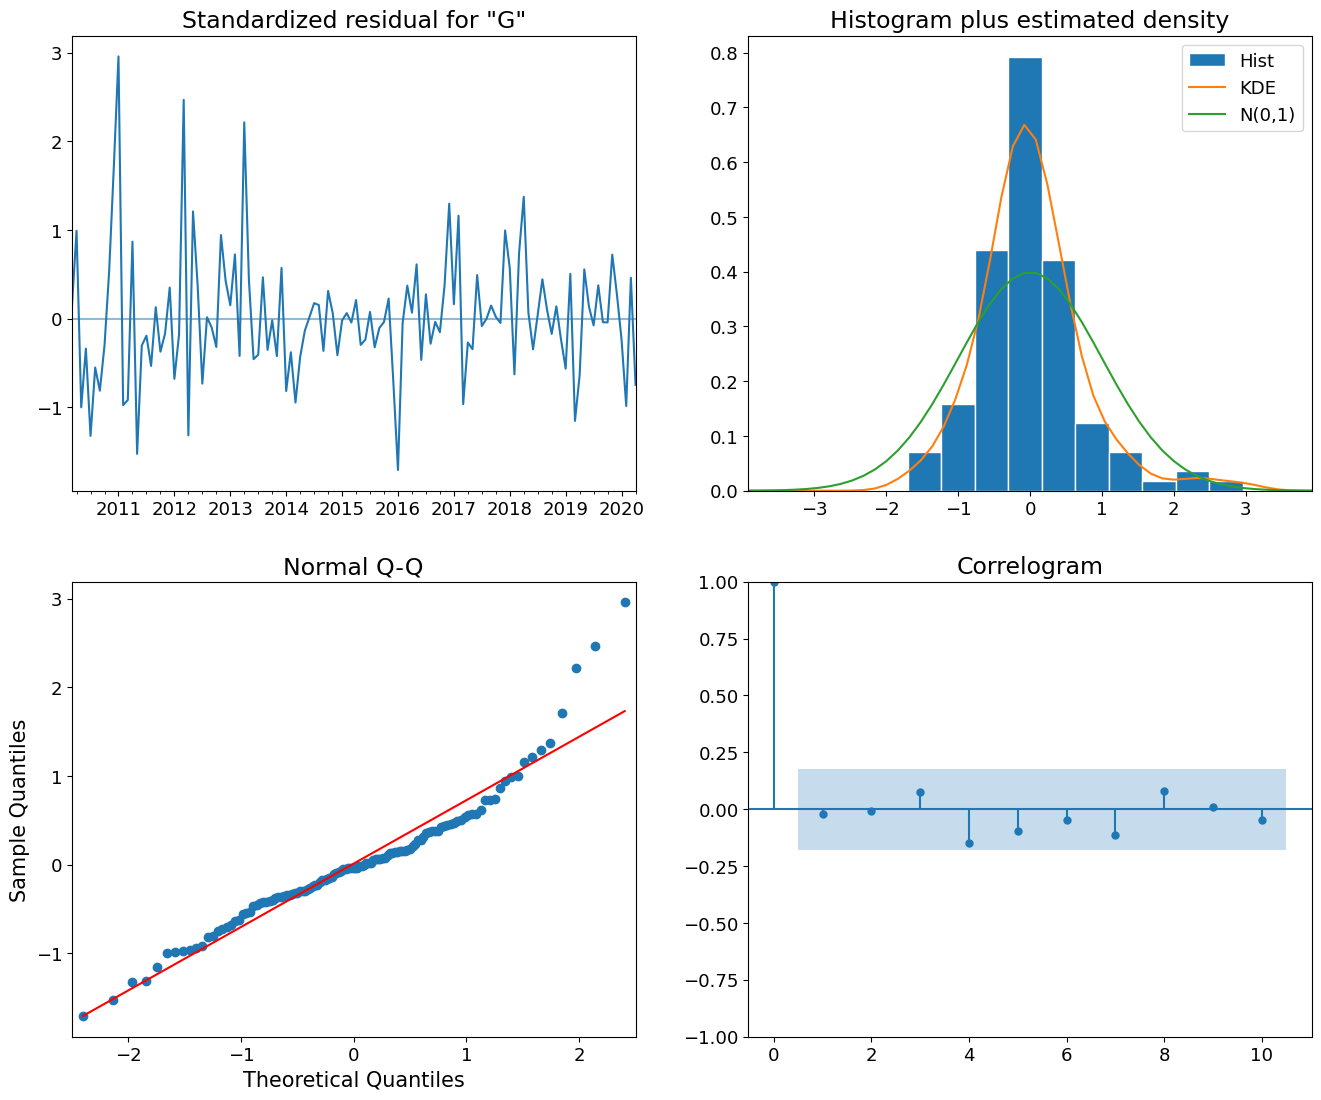

In [51]:
#plot diagnostics
y_train_fitx3.plot_diagnostics(figsize=(16, 13))
plt.show()

The residuals are normally distributed, with a small right skew. This is evident both in the histogram and the Q-Q plots. From the Standardized residual plot, it looks like the residuals are homoscedastic (ie, they have constant variance, and seem centered around zero). The randomness of the residuals can also be seen in the Correlogram, as all other lags except for 0 are within the shaded region. Given the results of the diagnostic plots, the model seems reliable. 

We can also plot the residuals of our the best-performing SARIMA model (y_train_fit4).

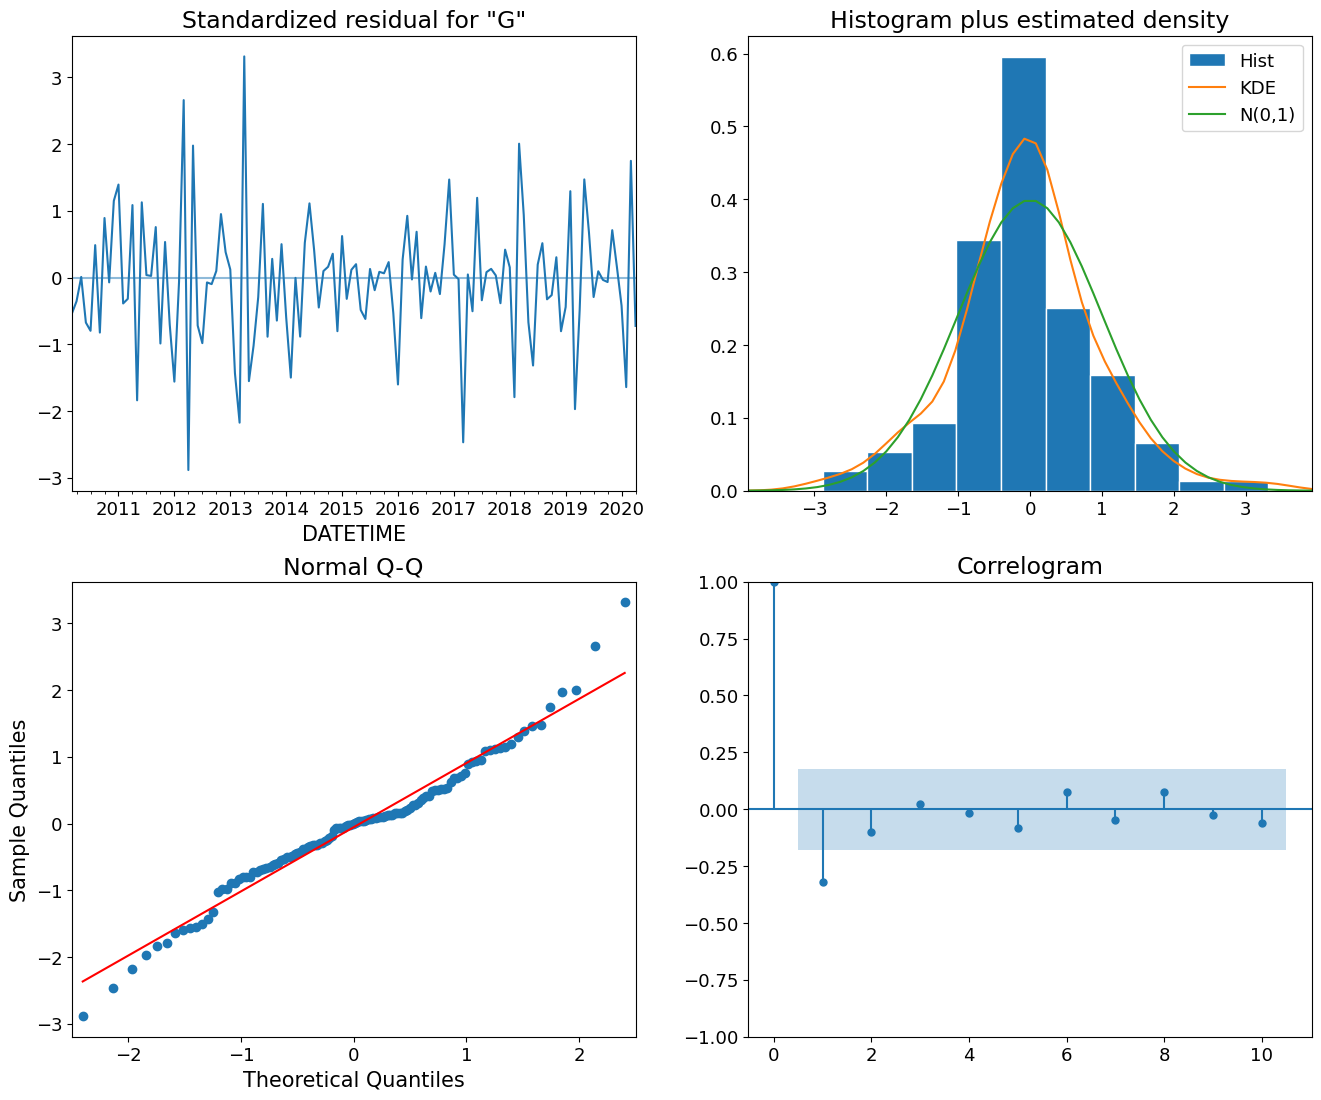

In [52]:
#plot diagnostics
y_train_fit4.plot_diagnostics(figsize=(16, 13))
plt.show()

The residuals seem mostly normally distributed, with similar homscedasticity. (There is a slightly larger right skew in the Histogram, and 1 lag outside the shaded region in the Correlogram.)

The reliability of the models may become more evident once we use them to forecast future values beyond the sample dataset and check the performance of the models on those values.

### **SARIMA/SARIMAX: Forecasting**

The first step is to check the chronological endpoint of the Train set. This is to ensure we don't include any data from the Test set in our future values forecasting, and can keep the Training data separate from the Test data when we run our predictions.

In [53]:
X_train

DATETIME
2009-02-01 00:00:00+00:00    65475735.0
2009-03-01 00:00:00+00:00    58323292.0
2009-04-01 00:00:00+00:00    58954386.0
2009-05-01 00:00:00+00:00    51068026.0
2009-06-01 00:00:00+00:00    50402036.0
                                ...    
2019-12-01 00:00:00+00:00    53076372.0
2020-01-01 00:00:00+00:00    53625057.0
2020-02-01 00:00:00+00:00    54228971.0
2020-03-01 00:00:00+00:00    50274387.0
2020-04-01 00:00:00+00:00    50630953.0
Freq: MS, Name: GENERATION, Length: 135, dtype: float64

The last data point in the training set is midnight on 01 April, 2020 (2020-04-01 00:00:00+00:00). As such, we'll slice that dataset starting from May 2020.

In [54]:
next_date = g_monthly.index[g_monthly.index.get_loc(X_train.index[-1])+1]

next_date

Timestamp('2020-05-01 00:00:00+0000', tz='UTC')

While the g_monthly dataset ends in February 2024, the monthly_pop dataframe includes OECD population data to 2050 (allowing us a DateTime index that stretches the full length of our prediction timeline). 

In [55]:
#reminder view of the data
monthly_pop

,DATETIME,UK population
0,2009-01-01,61423720
1,2009-02-01,61423720
2,2009-03-01,61423720
3,2009-04-01,61423720
4,2009-05-01,61423720
...,...,...
488,2049-09-01,76677270
489,2049-10-01,76677270
490,2049-11-01,76677270
491,2049-12-01,76677270


Unlike g_monthly, each row of data in monthly_pop is month-end rather than month-start. When slicing the data, we'll need to resample for month-start (ie, resample('MS')).

In [56]:
#setting variable to call as exogenous variable in forecasting
future_pop_exog = monthly_pop.set_index('DATETIME').resample('MS').mean()['UK population'][next_date.tz_localize(None):]

In [57]:
future_pop_exog

DATETIME
2020-05-01    66754050.0
2020-06-01    66754050.0
2020-07-01    66754050.0
2020-08-01    66754050.0
2020-09-01    66754050.0
                 ...    
2049-09-01    76677270.0
2049-10-01    76677270.0
2049-11-01    76677270.0
2049-12-01    76677270.0
2050-01-01    76958580.0
Freq: MS, Name: UK population, Length: 357, dtype: float64

Next, we'll calculate the steps remaining from the end of the Training dataset (April 2020) to end of the forecasted period (Dec 2049). This is because we've trained our model on the Training set. We must forecast values from its end so that we have overalapping values on which to evaluate our model (ie, we will compare the forecasted values for the DateTime index of the Test set against actual Test set values.)

In [58]:
#forecast future values

#2020 remaining months after April 2020
rem_20 = 12 - 4

#months from Jan 2021 to Dec 2049
future_mon = (2050-2021)*12

steps_test = rem_20 + future_mon
steps_test

356

Let's use the function defined at the start of this notebook to calculate metrics for the fitted SARIMA and SARIMAX models.

As a reminder, the evaluate_sarimax function requires the below arguments:

- fitted_model_list

- X_train

- y_train

- y_test

- future_exog

- steps_test

- train_mean

In [59]:
#fitted models
sarimax_fitted_models = [y_train_fit, y_train_fit2, y_train_fit3, y_train_fit4, y_train_fitx, y_train_fitx2, y_train_fitx3]

evaluate_sarimax(sarimax_fitted_models, X_train, y_train, y_test, future_pop_exog, steps_test, gen_mean)

Model 1 Train MAPE: 8.31%
Model 1 Test MAPE: 8.31%
Model 1 Train RMSE (abs): 9055336.82806982
Model 1 Train RMSE (%): 18.0%
Model 1 Test RMSE (abs): 5110145.928426082
Model 1 Test RMSE (%): 10.0%
Model 2 Train MAPE: 8.25%
Model 2 Test MAPE: 6.15%
Model 2 Train RMSE (abs): 9155185.118233582
Model 2 Train RMSE (%): 18.0%
Model 2 Test RMSE (abs): 3419769.4104752014
Model 2 Test RMSE (%): 7.000000000000001%
Model 3 Train MAPE: 8.27%
Model 3 Test MAPE: 6.22%
Model 3 Train RMSE (abs): 9146156.51476338
Model 3 Train RMSE (%): 18.0%
Model 3 Test RMSE (abs): 3431329.809139523
Model 3 Test RMSE (%): 7.000000000000001%
Model 4 Train MAPE: 8.08%
Model 4 Test MAPE: 6.47%
Model 4 Train RMSE (abs): 8687809.956464708
Model 4 Train RMSE (%): 17.0%
Model 4 Test RMSE (abs): 3736606.240854046
Model 4 Test RMSE (%): 7.000000000000001%
Model 5 Train MAPE: 16.22%
Model 5 Test MAPE: 7.01%
Model 5 Train RMSE (abs): 47041814.31518387
Model 5 Train RMSE (%): 93.0%
Model 5 Test RMSE (abs): 3800880.6566336183
Mode

([8.305942036559468,
  8.250720794667556,
  8.271519193621542,
  8.078571680439088,
  16.215585030430564,
  16.319847962087433,
  6.260798994416707],
 [8.309762886298042,
  6.15020578933464,
  6.219147490594048,
  6.473921815625807,
  7.014010136565332,
  7.037825098410696,
  7.025423654826507],
 [9055336.82806982,
  9155185.118233582,
  9146156.51476338,
  8687809.956464708,
  47041814.31518387,
  47649666.59809166,
  4297096.687791129],
 [5110145.928426082,
  3419769.4104752014,
  3431329.809139523,
  3736606.240854046,
  3800880.6566336183,
  3812559.5382514396,
  3875717.1444631997])

Next, we'll plot the forecasted and backcasted values against the known values in our dataset to visualise the accuracy of our model. Filtering based on lowest Test MAPE and Test RMSE scores, the best-performing SARIMA model was **y_train_fit2** and the best-performing SARIMAX model was **y_train_fitx**.

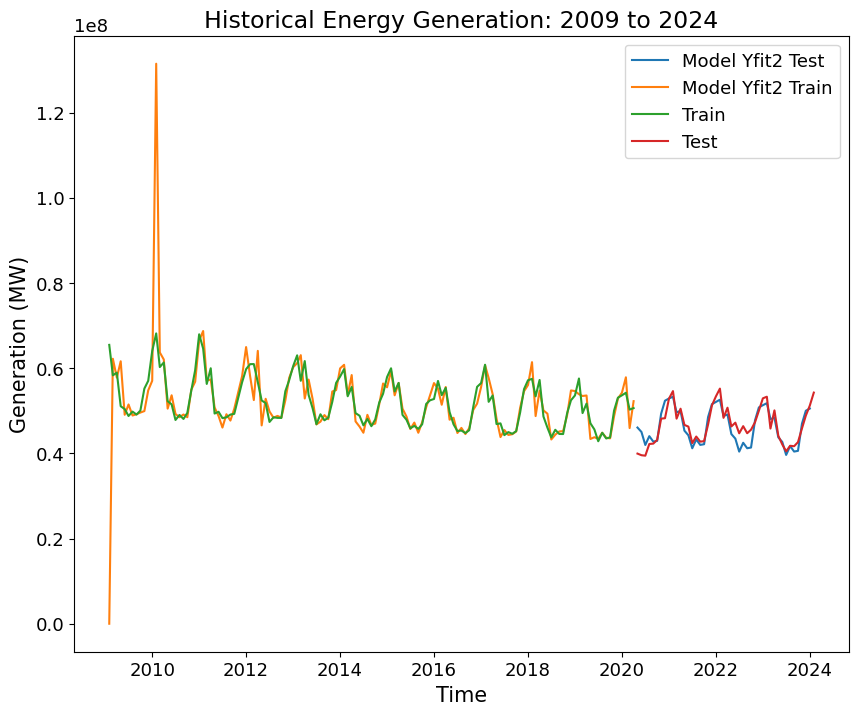

In [60]:
#calculations for traincast, testcast, forecast (ie, the model's predictions for X_train and X_test)
fit2_traincast = y_train_fit2.predict(start=0, end=len(X_train)-1)
fit2_testcast = y_train_fit2.forecast(steps=len(X_test)-1)

plt.figure(figsize=(10, 8))
plt.plot(fit2_testcast, label="Model Yfit2 Test")
plt.plot(fit2_traincast, label="Model Yfit2 Train")
plt.plot(X_train, label="Train")
plt.plot(X_test, label="Test")
plt.xlabel("Time")
plt.ylabel("Generation (MW)")
plt.title("Historical Energy Generation: 2009 to 2024")
plt.legend()
plt.savefig('y_train_fit2_matching.png', dpi=300)

There is an outlier at the start of the Model Yfit2 Train line, likely because for the first point in the plot, the model has no previous point of reference on which to make a prediction, and so started plotting at zero. (In a time series model, future predictions are calculated from known past values.) There is also a visual spike/outlier in Feb 2010 (ie, the first prediction the model made was Feb 2009), likely due to the seasonality component (ie, hyperparameter s = 12) and opposite effect of plotting the first point. To avoid the outliers, and  to better visualise the scale of the plot, we can start plotting the predicted values for X_train from step 13 (ie, the point after the second outlier occurs).

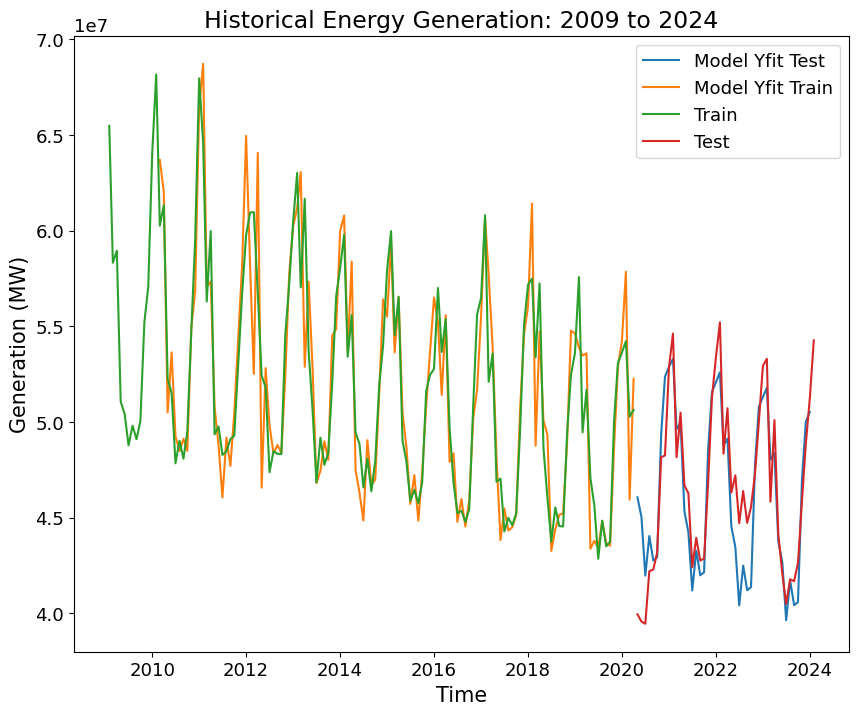

In [61]:
#y_train_fit4
fit2_traincast = y_train_fit2.predict(start=13, end=len(X_train)-1)
fit2_testcast = y_train_fit2.forecast(steps=len(X_test)-1)


plt.figure(figsize=(10, 8))
plt.plot(fit2_testcast, label="Model Yfit Test")
plt.plot(fit2_traincast, label="Model Yfit Train")
plt.plot(X_train, label="Train")
plt.plot(X_test, label="Test")
plt.xlabel("Time")
plt.ylabel("Generation (MW)")
plt.title("Historical Energy Generation: 2009 to 2024")
plt.legend()
plt.savefig('y_train_fit2_matching_delay.png', dpi=300)

We can see that the model's overlap of predicted values with real values is for some later dates in the Test set (ie, it's difficult to predict outlier events, such as the irregular pattern in the summer periods of 2020 and 2023).

Let's also plot the forecasted values.

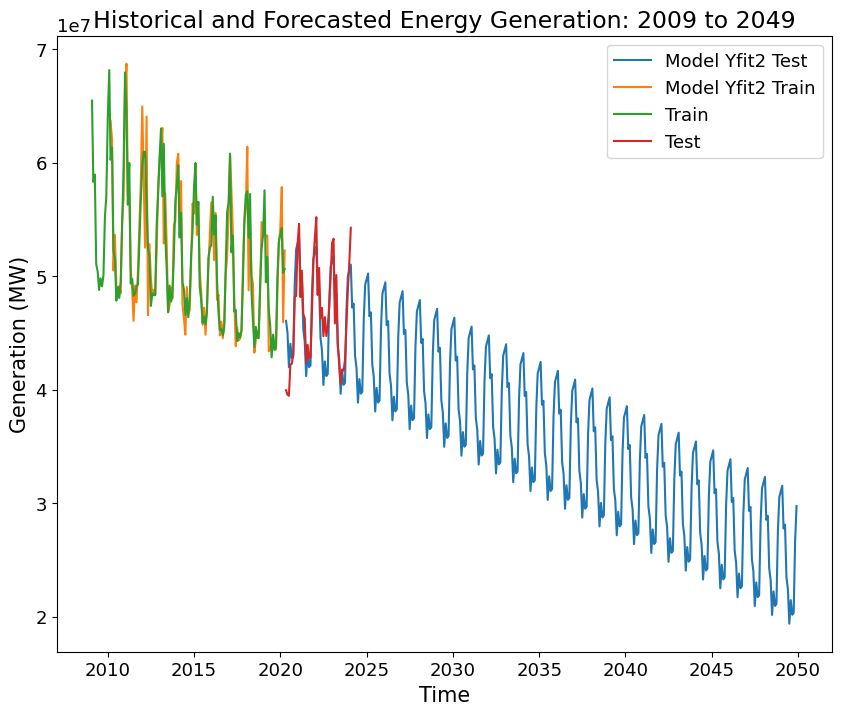

In [62]:
#y_train_fit4
fit2_forecast = y_train_fit2.forecast(steps=steps_test)
fit2_backcast = y_train_fit2.predict(start=13, end=len(X_train)-1)

#y_train_pred_gen4 = y_train_fit4.forecast(steps= steps, exog=future_pop_exog[:steps])
#y_train_pred_gen4

plt.figure(figsize=(10, 8))
plt.plot(fit2_forecast, label="Model Yfit2 Test")
plt.plot(fit2_backcast, label="Model Yfit2 Train")
plt.plot(X_train, label="Train")
plt.plot(X_test, label="Test")
plt.xlabel("Time")
plt.ylabel("Generation (MW)")
plt.title("Historical and Forecasted Energy Generation: 2009 to 2049")
plt.legend()
plt.savefig('y_train_fit2_forecasted2049.png', dpi=300)

When plotting the forecasted values, the limitations of time series modelling are more visually evident. The clear downward trend from the decomposition conducted in the Advanced EDA notebook is visible here, too. 

Let's plot the forecasted values from y_train_fitx as well.

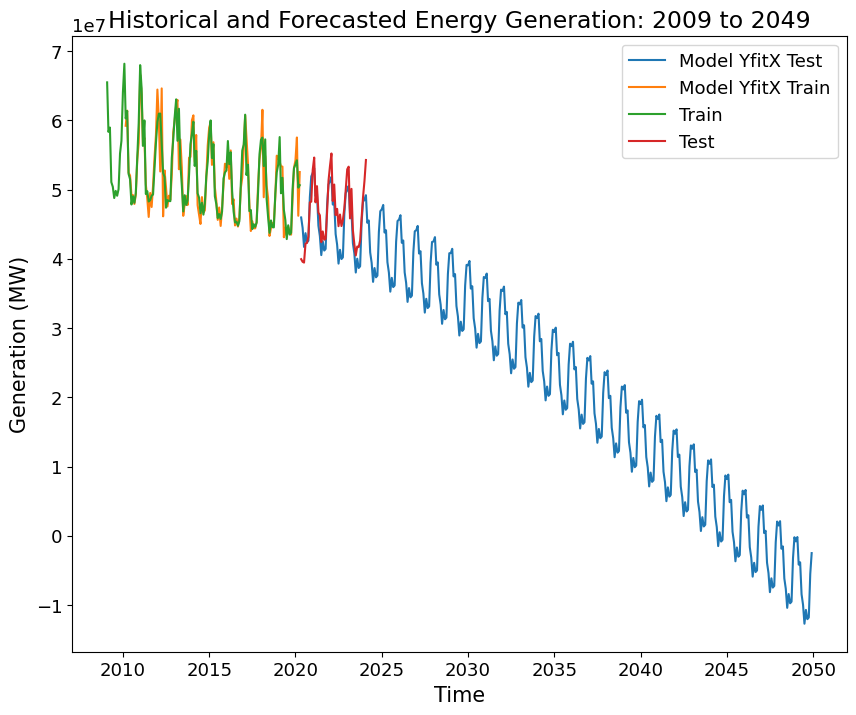

In [63]:
fitx_forecast = y_train_fitx.forecast(steps=steps_test, exog=future_pop_exog[:steps_test])
fitx_backcast = y_train_fitx.predict(start=13, end=len(X_train)-1)

plt.figure(figsize=(10, 8))
plt.plot(fitx_forecast, label="Model YfitX Test")
plt.plot(fitx_backcast, label="Model YfitX Train")
plt.plot(X_train, label="Train")
plt.plot(X_test, label="Test")
plt.xlabel("Time")
plt.ylabel("Generation (MW)")
plt.title("Historical and Forecasted Energy Generation: 2009 to 2049")
plt.legend()
plt.savefig('y_train_fitx_matching.png', dpi=300)

.........oh dear. For the SARIMAX model, the forecasted values are now predicting a negative energy generation in beginning just prior to 2045. That is a highly unlikely real-world scenario.

One of the clear limitations of time series models is the reliance on existing trends in the data. Given the external effects on energy consumption, such as the advent of technologies like electric vehicles, (which add pressure to existing electricity demand), it's unlikely that consumption will decline ad infinitum into the future. As such, it makes sense to  consider the growth and decline of energy sources individually, rather than as a whole.

Let's review the 'generation' dataframe and summarise the historical and present energy generation. We can compare 2009 and 2023, the first and last complete years of values in the dataset.

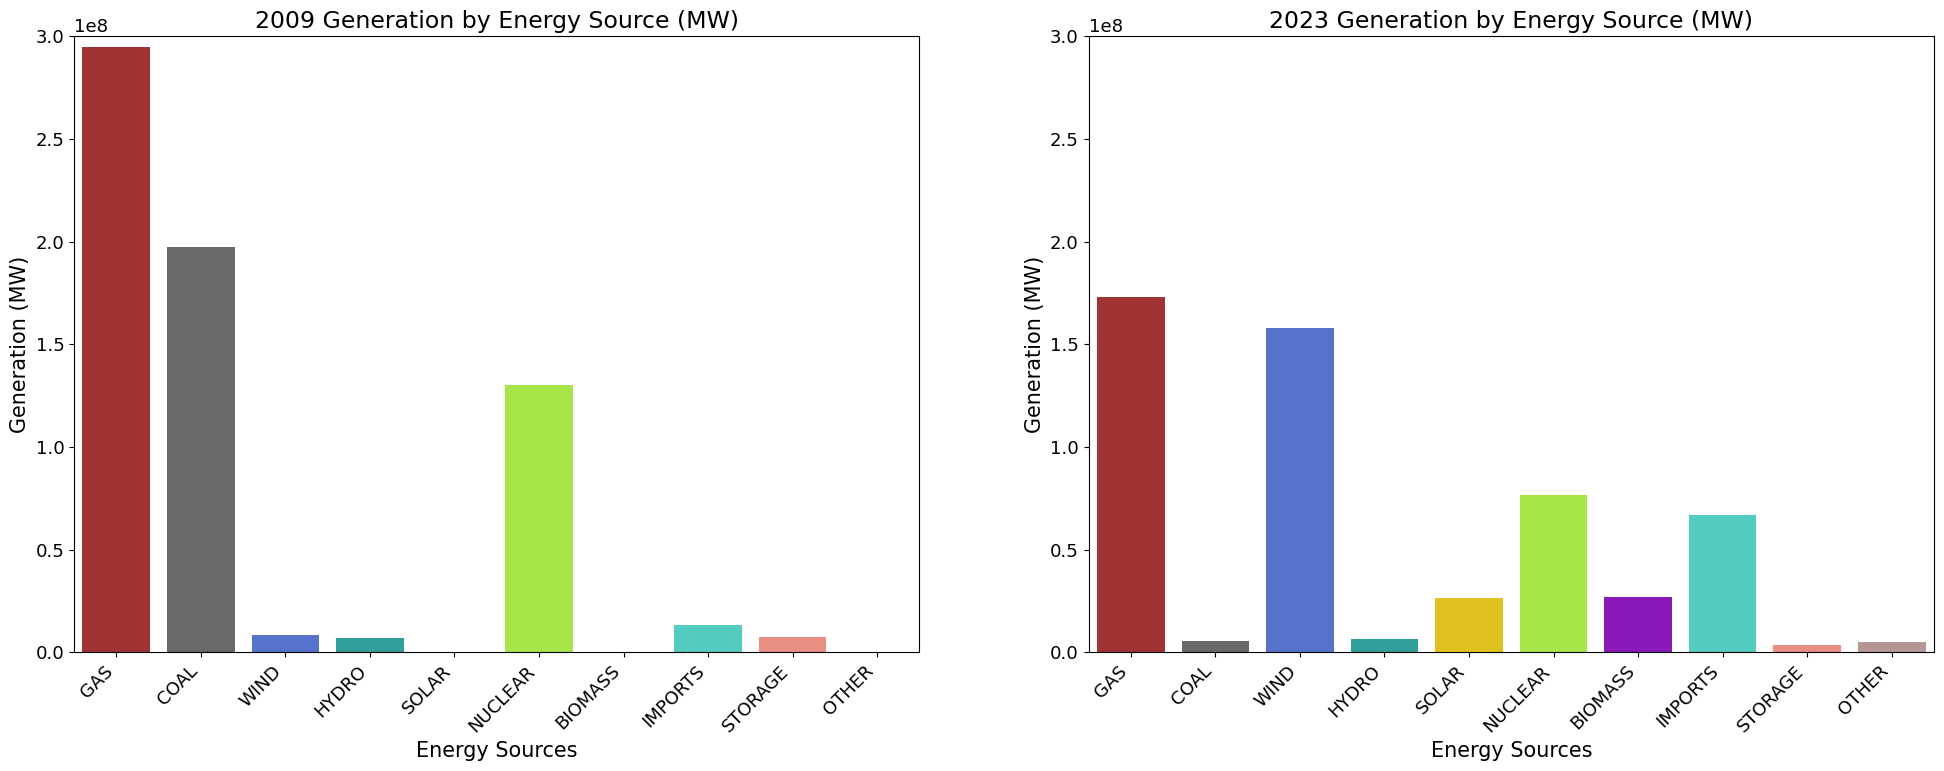

<Figure size 1600x800 with 0 Axes>

In [64]:
#list of energy sources
energy_sources = ['GAS', 'COAL', 'WIND', 'HYDRO', 'SOLAR', 'NUCLEAR', 'BIOMASS', 'IMPORTS', 'STORAGE', 'OTHER']

#total generation by energy source
annual_energy_sum = generation[energy_sources].groupby(generation.index.year).sum()

colors = {'GAS': 'firebrick', 'COAL': 'dimgray', 'WIND': 'royalblue', 'HYDRO': 'lightseagreen', 'SOLAR': 'gold',  
          'NUCLEAR': 'greenyellow', 'BIOMASS': 'darkviolet', 'IMPORTS':'turquoise', 'STORAGE': 'salmon', 'OTHER': 'rosybrown'}

#filtering for years 2009 and 2023
energy_2009 = annual_energy_sum.loc[2009]
energy_2023 = annual_energy_sum.loc[2023]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,8))

#2009
energy_2009_df = energy_2009.reset_index().rename(columns={'index': 'Energy Sources', energy_2009.name:'Generation (MW)'})
sns.barplot(x='Energy Sources', y='Generation (MW)', data=energy_2009_df, palette=colors, ax=axes[0])
axes[0].set_title('2009 Generation by Energy Source (MW)')
axes[0].set_ylabel('Generation (MW)')
axes[0].set_xlabel('Energy Sources')
axes[0].set_xticklabels(energy_2009_df['Energy Sources'], rotation=45, ha='right')
axes[0].set_ylim(0, 300000000)

#2023
energy_2023_df = energy_2023.reset_index().rename(columns={'index': 'Energy Sources', energy_2023.name: 'Generation (MW)'})
sns.barplot(x='Energy Sources', y='Generation (MW)', data=energy_2023_df, palette=colors, ax=axes[1])
axes[1].set_title('2023 Generation by Energy Source (MW)')
axes[1].set_ylabel('Generation (MW)')
axes[1].set_xlabel('Energy Sources')
axes[1].set_xticklabels(energy_2023_df['Energy Sources'], rotation=45, ha='right')
axes[1].set_ylim(0, 300000000)

plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size':17})
plt.savefig('2009_2023_gen_by_source.png', dpi=300)

While there has been a clear decline in the generation of energy from most energy sources, some renewable energy sources have grown their generation over the past 15 years. Most notably, Wind looks to have grown its total generation exponentially.

The downward trend seen in the time series decomposition in the Advanced EDA notebook and from the plots above are likely from a combined decline in gas and coal as part of UK's transition away from fossil fuels. To better account for the individual growth seen in these plots (ie, Wind, Solar, Biomass, and Imports), we can forecast values for individual energy sources.

Let's start with Wind, as it has the most visually apparent growth in total energy generation from 2009 to 2023.

In [65]:
wind_2009 = generation.loc['2009']['WIND'].sum()
wind_2023 = generation.loc['2023']['WIND'].sum()

gas_2009 = generation.loc['2009']['GAS'].sum()
gas_2023 = generation.loc['2023']['GAS'].sum()

print(f'Wind as percentage of Gas (2009): {(wind_2009/gas_2009)*100}')
print(f'Wind as percentage of Gas (2023): {(wind_2023/gas_2023)*100}')

Wind as percentage of Gas (2009): 2.8202085921441418
Wind as percentage of Gas (2023): 91.33840201053069


By comparing the total annual energy generation from 2009 to 2023 (the first complete year and last complete year of data), we can confirm from the data that Wind energy generation has grown the most significantly. In fact, Wind energy generation in 2023 almost matches that of Gas.

This begs the question: If the UK were to fully move away from fossil fuels, does the model predict that UK Wind energy generation in 2049 would be twice what it is today? (ie, would there be enough Wind energy generated be doubled, to fill the gap left by Gas generation that would decline to near zero?)

### **SARIMAX: Individual Energy Source Modelling**

Before we model individual energy sources, we'll need to re-do the Train/Test split. This is because our first Train/Test split was only done on the 'GENERATION' column. We'll need to re-split using the entirety of the dataframe, so that we can call the individual energy source columns for each of the individual models.

Since we concatenated future population values onto our original G-monthly, we'll need to drop those rows of future values before we do the train/test split.

In [66]:
g_monthly2 = g_monthly.loc[:'2024-02']
g_monthly2

,GAS,COAL,NUCLEAR,WIND,HYDRO,IMPORTS,BIOMASS,SOLAR,STORAGE,GENERATION,RENEWABLE,FOSSIL,population
DATETIME,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,22765366.0,30849365.0,8623216.0,862478.0,811042.0,882060.0,0.0,0.0,682214.0,65475735.0,1673513.0,53614734.0,61423720
2009-02-01 00:00:00+00:00,19651944.0,25219773.0,10836805.0,564923.0,542855.0,831729.0,0.0,0.0,675286.0,58323292.0,1107790.0,44871717.0,61423720
2009-03-01 00:00:00+00:00,22881351.0,19929200.0,12675530.0,954612.0,861294.0,1025856.0,0.0,0.0,626558.0,58954386.0,1815914.0,42810548.0,61423720
2009-04-01 00:00:00+00:00,22166365.0,13295828.0,12074650.0,634044.0,558552.0,1898691.0,0.0,0.0,439888.0,51068026.0,1192588.0,35462199.0,61423720
2009-05-01 00:00:00+00:00,23179257.0,12618719.0,10158450.0,812647.0,459668.0,2600090.0,0.0,0.0,573244.0,50402036.0,1272293.0,35797976.0,61423720
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01 00:00:00+00:00,12338224.0,726000.0,6371257.0,15316055.0,882318.0,5029141.0,2778050.0,1601574.0,323464.0,45865315.0,17799950.0,13064222.0,68043700
2023-11-01 00:00:00+00:00,15201270.0,1158663.0,5672885.0,14990727.0,676988.0,5981536.0,3403161.0,938528.0,334804.0,48858943.0,16606238.0,16359933.0,68043700
2023-12-01 00:00:00+00:00,13114424.0,605932.0,7237706.0,20745933.0,779497.0,4316784.0,2993227.0,414101.0,463434.0,51229568.0,21939533.0,13720353.0,68043700


In [67]:
#finding the first and last timestamps in the dataset
min_date = g_monthly2.index.min()
max_date = g_monthly2.index.max()

#delineating the cutoff date for the Train/Test split
train_percent = 0.75
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between

#create the train and test dataframes from the whole of the g_monthly data
y3 = g_monthly2
X3 = g_monthly2.shift(1)
X3.dropna(inplace=True) #due to the lag, the first value will be NaN, and thus needs to be dropped
y3 = y3.iloc[1:]

X3_train = X3[X3.index <= train_cutoff]
X3_test = X3[X3.index > train_cutoff]

y3_train = y3[y3.index <= train_cutoff]
y3_test = y3[y3.index > train_cutoff]

### SARIMAX: Wind

From the whole-dataframe Train/Test split, we'll do a Train/Test split just for the wind column

In [68]:
#train/test split for WIND
#create the train and test dataframes from the whole of the g_monthly data
y3_w = g_monthly2['WIND']
X3_w = g_monthly2['WIND'].shift(1)
X3_w.dropna(inplace=True) #due to the lag, the first value will be NaN, and thus needs to be dropped
y3_w = y3_w.iloc[1:]

X3_w_train = X3_w[X3_w.index <= train_cutoff]
X3_w_test = X3_w[X3_w.index > train_cutoff]

y3_w_train = y3_w[y3_w.index <= train_cutoff]
y3_w_test = y3_w[y3_w.index > train_cutoff]

We'll start with the same parameters as our best-fitted SARIMA model (y_train_fit2).

In [69]:
#setting hyperparameters:

p = 2

d = 1

q = 2

s = 12

P = 1

D = 1

Q = 1

sarimax_w = SARIMAX(X3_w_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
#instantiate SARIMAX with exogenous variable

#fit
y_train_fw = sarimax_w.fit(disp=0)

y_train_fw.summary()

/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 WIND   No. Observations:                  135
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1885.170
Date:                              Mon, 15 Apr 2024   AIC                           3784.341
Time:                                      15:16:25   BIC                           3803.969
Sample:                                  02-01-2009   HQIC                          3792.313
                                       - 04-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2163      0.819     -0.264      0.792      -1.821       1.388
ar.L2          0.2914      0.241      1.210      0.226      -0.181       0.764
ma.L1         -0.3592      0.816     -0.440      0.660      -1.958       1.240
ma.L2         -0.5095      0.731     -0.697      0.486      -1.942       0.923
ar.S.L12      -0.2212      0.298     -0.742      0.458      -0.805       0.363
ma.S.L12      -0.4821      0.284     -1.697      0.090      -1.039       0.075
sigma2       2.14e+12   1.64e-12   1.31e+24      0.000    2.14e+12    2.14e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.42
Prob(Q):                              0.99   Prob(JB):                         0.07
Heteroskedasticity (H):               7.98   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.47e+39. Standard errors may be unstable.
"""

This is not performing as hoped. None of the p-values for the coefficients are below 0.05, showing none of the hyperparameters (at their current settings) are strong predictors for the model. 

Out of curiosity, let's try the hyperparameters from the best-performing SARIMAX model, with the addition of the exogenous factor.

In [70]:
#referring back to the fitted SARIMAX model's hyperparameters:

p = 1

d = 1

q = 1

s = 12

P = 0

D = 1

Q = 2

#instantiate SARIMAX with exogenous variable
sarimax_w2 = SARIMAX(X3_w_train, order=(p, d, q), seasonal_order=(P, D, Q, s), exog=X_train_exog)

#fit
y_train_fw2 = sarimax_w2.fit(disp=0)

y_train_fw2.summary()

/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    WIND   No. Observations:                  135
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1887.182
Date:                                 Mon, 15 Apr 2024   AIC                           3786.363
Time:                                         15:16:27   BIC                           3803.187
Sample:                                     02-01-2009   HQIC                          3793.197
                                          - 04-01-2020                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
population    -0.0060      0.065     -0.093      0.926      -0.133       0.121
ar.L1          0.3573      0.162      2.211      0.027       0.041       0.674
ma.L1         -0.9107      0.090    -10.163      0.000      -1.086      -0.735
ma.S.L12      -0.7001      0.153     -4.568      0.000      -1.000      -0.400
ma.S.L24       0.1411      0.199      0.707      0.479      -0.250       0.532
sigma2      2.314e+12   1.07e-14   2.16e+26      0.000    2.31e+12    2.31e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 6.82
Prob(Q):                              0.75   Prob(JB):                         0.03
Heteroskedasticity (H):               8.04   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.35e+42. Standard errors may be unstable.
"""

Interestingly, all of the p-values are now below zero, except for the p-value of the population coefficient, which is 0.926 and strongly indicates it is not a good predictor for the model. Keeping the same hyperparameters, let's remove the exogenous factor from the model.

In [71]:
#setting hyperparameters:

p = 1

d = 1

q = 1

s = 12

P = 0

D = 1

Q = 2

#instantiate SARIMAX with exogenous variable
sarimax_w3 = SARIMAX(X3_w_train, order=(p, d, q), seasonal_order=(P, D, Q, s))

#fit
y_train_fw3 = sarimax_w3.fit(disp=0)

y_train_fw3.summary()

/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tonichan/anaconda3/envs/capstonetc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    WIND   No. Observations:                  135
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1887.258
Date:                                 Mon, 15 Apr 2024   AIC                           3784.516
Time:                                         15:16:27   BIC                           3798.536
Sample:                                     02-01-2009   HQIC                          3790.211
                                          - 04-01-2020                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3541      0.162      2.180      0.029       0.036       0.673
ma.L1         -0.9058      0.093     -9.745      0.000      -1.088      -0.724
ma.S.L12      -0.7010      0.153     -4.583      0.000      -1.001      -0.401
ma.S.L24       0.1414      0.198      0.713      0.476      -0.247       0.530
sigma2      2.317e+12   1.02e-14   2.26e+26      0.000    2.32e+12    2.32e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 5.72
Prob(Q):                              0.73   Prob(JB):                         0.06
Heteroskedasticity (H):               7.90   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.94e+42. Standard errors may be unstable.
"""

Similar to our best fitted SARIMAX model, the final model shows statistically-significant p-values for all coefficients except for ma.S.L24. Again, this could be the result of model overspecification, as unnecessary terms that don't contribute to the model can result in high p-values for those coefficients.

To check the reliability of the model, let's plot the residuals.

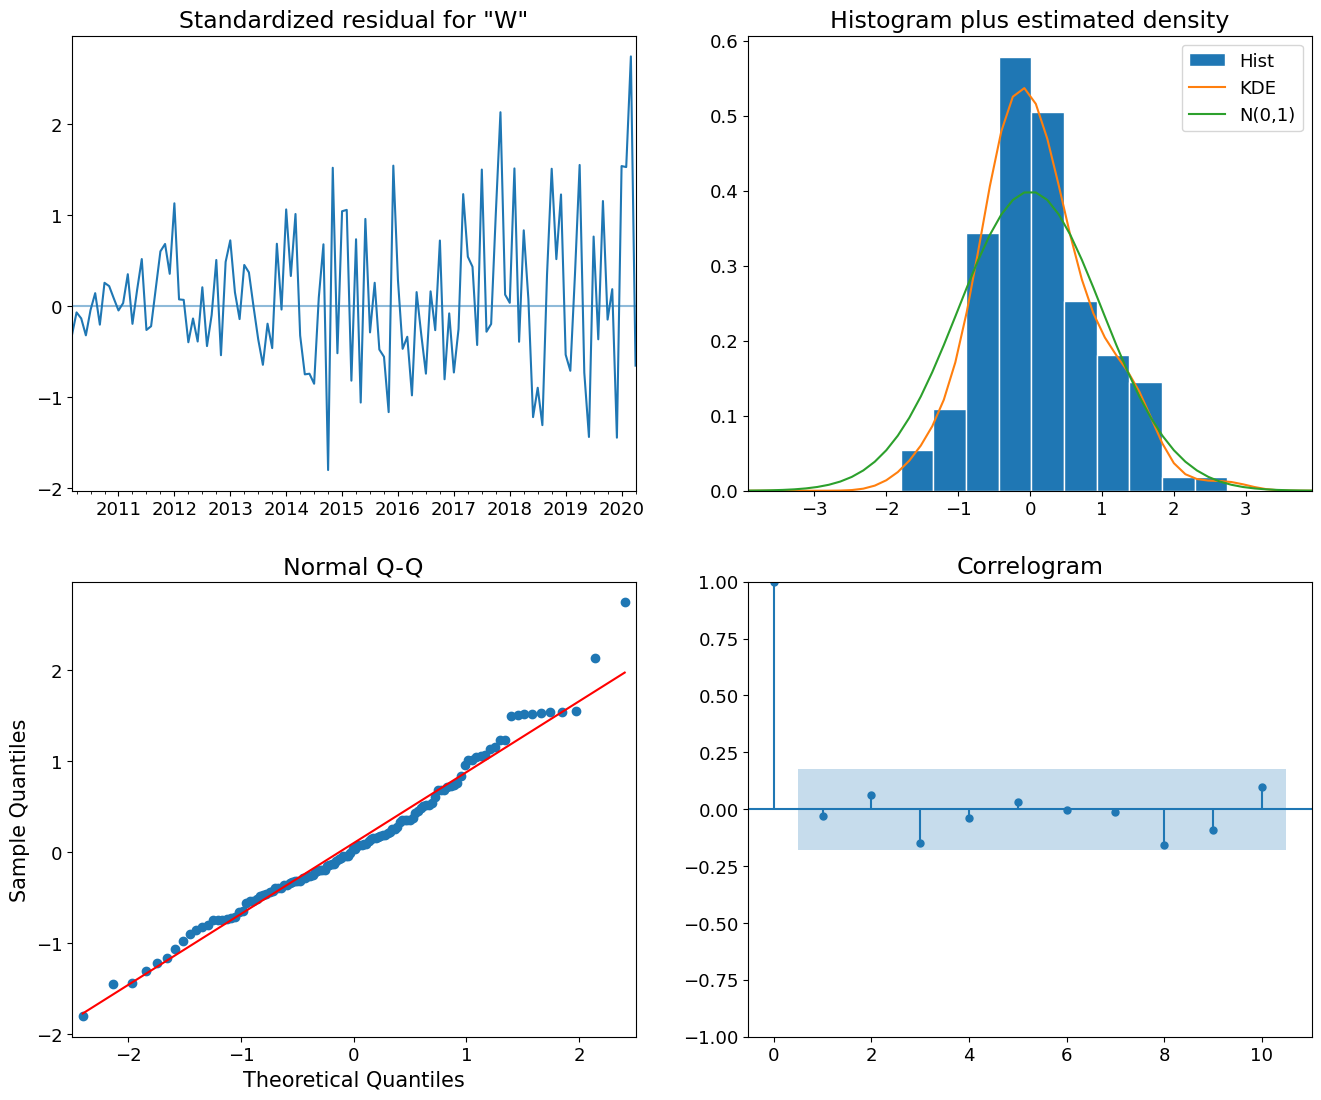

In [72]:
#plot diagnostics
y_train_fw3.plot_diagnostics(figsize=(16, 13))
plt.show()

The residuals look mostly normally distributed, with a slight right skew in the Histogram. This is evident in the Q-Q plot. None of the lags beyond 0 are outside of the shaded region in the Correlogram, and the residuals seem fairly homoscedastic, ie, centered around zero, in the Standardized Residuals plot. Based on the residuals, this model seems like it should be reliable.

In [73]:
#fitted models
fitted_wind_list = [y_train_fw, y_train_fw2, y_train_fw3]
wind_mean = g_monthly2['WIND'].mean()

evaluate_sarimax(fitted_wind_list, X3_w_train, y3_w_train, y3_w_test, future_pop_exog, steps_test, wind_mean)

Model 1 Train MAPE: 28.47%
Model 1 Test MAPE: 31.48%
Model 1 Train RMSE (abs): 1509744.1558275565
Model 1 Train RMSE (%): 23.0%
Model 1 Test RMSE (abs): 3727486.4935256853
Model 1 Test RMSE (%): 56.00000000000001%
Model 2 Train MAPE: 30.43%
Model 2 Test MAPE: 31.55%
Model 2 Train RMSE (abs): 1499101.0128154736
Model 2 Train RMSE (%): 23.0%
Model 2 Test RMSE (abs): 3749197.110973621
Model 2 Test RMSE (%): 56.99999999999999%
Model 3 Train MAPE: 28.68%
Model 3 Test MAPE: 32.05%
Model 3 Train RMSE (abs): 1498748.245074414
Model 3 Train RMSE (%): 23.0%
Model 3 Test RMSE (abs): 3801501.4731009733
Model 3 Test RMSE (%): 56.99999999999999%


([28.468934303935455, 30.429418317139582, 28.68148654071546],
 [31.483496994003858, 31.54674562219845, 32.04858851327405],
 [1509744.1558275565, 1499101.0128154736, 1498748.245074414],
 [3727486.4935256853, 3749197.110973621, 3801501.4731009733])

Despite the variance in hyperparameters and the inclusion/exclusion of the exogenous factor, the metrics for the three models are very similar. Among the three, the range in Test MAPE is 31.5% to 32.1%, and the range in Test RMSE is 56% to 57%. 

While an RMSE score (ie, margin of error) greater than 50% implies the model is less accurate than random chance, it also potentially indicates high volatility in Wind production. 

To check this, we can plot the predicted values.

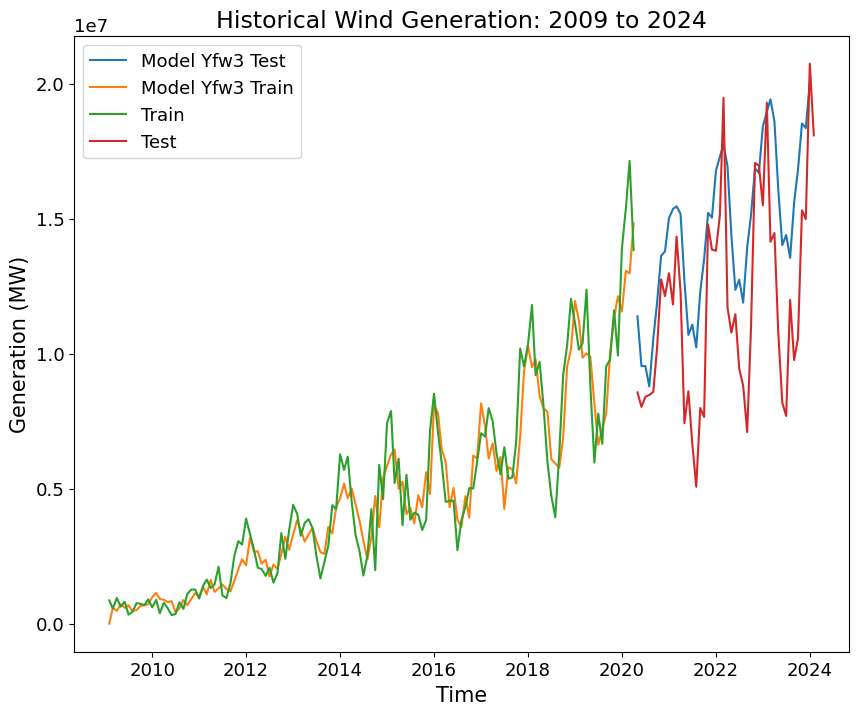

In [74]:
#y_train_fw3
fw3_traincast = y_train_fw3.predict(start=0, end=len(X3_w_train)-1)
fw3_testcast = y_train_fw3.forecast(steps=len(X3_w_test)-1)


plt.figure(figsize=(10, 8))
plt.plot(fw3_testcast, label="Model Yfw3 Test")
plt.plot(fw3_traincast, label="Model Yfw3 Train")
plt.plot(X3_w_train, label="Train")
plt.plot(X3_w_test, label="Test")
plt.xlabel("Time")
plt.ylabel("Generation (MW)")
plt.title("Historical Wind Generation: 2009 to 2024")
plt.legend()
plt.savefig('y_train_fw3_matching.png', dpi=300)

As suspected, there is a lack of overlap between the predicted Test set values (testcast) and the actual Test set values. It can be seen from the red Test line in the plot that there was quite a bit of volatility in recent years, which the model found difficult to capture.

Unlike the plot for the best fitted Generation model, this plot had no large visual outliers at the beginning of the predicted Training set values, likely because Wind generation levels were a lot closer to zero in 2009.

Let's plot the forecasted values as well.

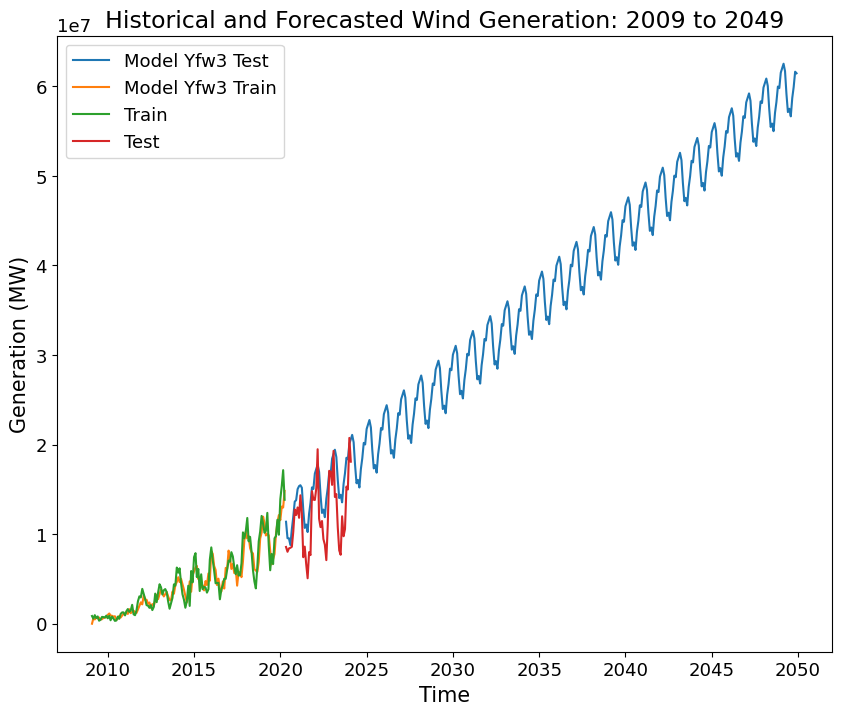

In [75]:
#y_train_fit4
fw3_traincast = y_train_fw3.predict(start=0, end=len(X3_w_train)-1)
fw3_forecast = y_train_fw3.forecast(steps=steps_test)


plt.figure(figsize=(10, 8))
plt.plot(fw3_forecast, label="Model Yfw3 Test")
plt.plot(fw3_traincast, label="Model Yfw3 Train")
plt.plot(X3_w_train, label="Train")
plt.plot(X3_w_test, label="Test")
plt.xlabel("Time")
plt.ylabel("Generation (MW)")
plt.title("Historical and Forecasted Wind Generation: 2009 to 2049")
plt.legend()
plt.savefig('y_train_fw3_forecasted2049.png', dpi=300)

The most obvious difference between this plot and the plot of forecasted values for total energy generation ("Historical and Forecasted Energy Generation: 2009 to 2049") is that the forecasted total energy generation declined over time, while forecasted wind energy generation grows over time. This is much more promising for UK net zero 2050! 

Let's save this fitted model to a .pkl file for later use.

In [76]:
with open('wind_generation_sarima_model.pkl', 'wb') as pkl_file:
    pickle.dump(y_train_fw3, pkl_file)

print('Model saved as wind_generation_sarima_model.pkl')

Model saved as wind_generation_sarima_model.pkl


In [77]:
#saving the Test set (X3_w_test) as .csv to feed into the model for predictions
#no need to save X3_w_train as the trained model and coefficients are stored in the .pkl file
X3_w_test.to_csv('wind_gen_model_data_feed.csv', header=True)

Although the SARIMA model may have difficulty predicting volatility as seen in the Test values, this conversely means it is likely more reliable at making stable, future predictions (ie, it is not reliable at a granular level, or for a single datapoint, but it can be more reliable with long-term predictions).

Generally speaking however, predictive models are less reliable the farther into the future the predicted values go, simply because the passing of time allows for external factors to have greater effect on actual values.

That said, it may still be worth answering the previous question: does the model predict that UK Wind energy generation in 2049 would be twice what it is today? (ie, would there be enough Wind energy generated be doubled, to fill the gap left by Gas generation that would decline to near zero?)

To more easily compare the predicted values against values in the existing dataset, let's merge the predicted Wind and Generation values back into the original dataframe.

In [78]:
#list of predicted Wind generation values from fitted model y_train_fw3
y_train_pred_wind = y_train_fw3.forecast(steps= steps_test).loc['2024-03':]
y_train_pred_wind

2024-03-01 00:00:00+00:00    2.108527e+07
2024-04-01 00:00:00+00:00    2.025878e+07
2024-05-01 00:00:00+00:00    1.772264e+07
2024-06-01 00:00:00+00:00    1.568266e+07
2024-07-01 00:00:00+00:00    1.605875e+07
                                 ...     
2049-08-01 00:00:00+00:00    5.665331e+07
2049-09-01 00:00:00+00:00    5.870145e+07
2049-10-01 00:00:00+00:00    5.991469e+07
2049-11-01 00:00:00+00:00    6.163407e+07
2049-12-01 00:00:00+00:00    6.145969e+07
Freq: MS, Name: predicted_mean, Length: 310, dtype: float64

#### Merging results

Let's merge our results back onto the g_monthly dataframe.

Since the best-fitted SARIMAX model for total generation predicted negative energy generation in 2049, let's instead use the best-fitted SARIMA model's predicted values (ie, y_train_fit2).

In [79]:
forecast_f2_gen = y_train_fit2.forecast(steps=steps_test)
forecast_f2_gen

2020-05-01 00:00:00+00:00    4.606262e+07
2020-06-01 00:00:00+00:00    4.502822e+07
2020-07-01 00:00:00+00:00    4.196996e+07
2020-08-01 00:00:00+00:00    4.404235e+07
2020-09-01 00:00:00+00:00    4.276109e+07
                                 ...     
2049-08-01 00:00:00+00:00    2.144363e+07
2049-09-01 00:00:00+00:00    2.015833e+07
2049-10-01 00:00:00+00:00    2.032279e+07
2049-11-01 00:00:00+00:00    2.670759e+07
2049-12-01 00:00:00+00:00    2.974422e+07
Freq: MS, Name: predicted_mean, Length: 356, dtype: float64

In [80]:
#make a copy of the g_monthly dataframe
g_monthly_pred = g_monthly.copy()

In [81]:
#merge UK population and total population columns
g_monthly_pred['GENERATIONcurr_fcast'] = g_monthly_pred['GENERATION'].combine_first(forecast_f2_gen)

In [82]:
g_monthly_pred.drop(['GENERATION'], axis=1, inplace=True)



In [83]:
#drop
g_monthly_pred.drop(g_monthly_pred.index[-1], inplace=True)

g_monthly_pred

,GAS,COAL,NUCLEAR,WIND,HYDRO,IMPORTS,BIOMASS,SOLAR,STORAGE,RENEWABLE,FOSSIL,population,GENERATIONcurr_fcast
DATETIME,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,22765366.0,30849365.0,8623216.0,862478.0,811042.0,882060.0,0.0,0.0,682214.0,1673513.0,53614734.0,61423720,6.547574e+07
2009-02-01 00:00:00+00:00,19651944.0,25219773.0,10836805.0,564923.0,542855.0,831729.0,0.0,0.0,675286.0,1107790.0,44871717.0,61423720,5.832329e+07
2009-03-01 00:00:00+00:00,22881351.0,19929200.0,12675530.0,954612.0,861294.0,1025856.0,0.0,0.0,626558.0,1815914.0,42810548.0,61423720,5.895439e+07
2009-04-01 00:00:00+00:00,22166365.0,13295828.0,12074650.0,634044.0,558552.0,1898691.0,0.0,0.0,439888.0,1192588.0,35462199.0,61423720,5.106803e+07
2009-05-01 00:00:00+00:00,23179257.0,12618719.0,10158450.0,812647.0,459668.0,2600090.0,0.0,0.0,573244.0,1272293.0,35797976.0,61423720,5.040204e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049-08-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76677270,2.144363e+07
2049-09-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76677270,2.015833e+07
2049-10-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76677270,2.032279e+07


In [84]:
forecast_wind = y_train_fw3.forecast(steps=steps_test, exog=future_pop_exog[:steps_test])
forecast_wind

2020-05-01 00:00:00+00:00    1.138785e+07
2020-06-01 00:00:00+00:00    9.544190e+06
2020-07-01 00:00:00+00:00    9.545450e+06
2020-08-01 00:00:00+00:00    8.792315e+06
2020-09-01 00:00:00+00:00    1.055462e+07
                                 ...     
2049-08-01 00:00:00+00:00    5.665331e+07
2049-09-01 00:00:00+00:00    5.870145e+07
2049-10-01 00:00:00+00:00    5.991469e+07
2049-11-01 00:00:00+00:00    6.163407e+07
2049-12-01 00:00:00+00:00    6.145969e+07
Freq: MS, Name: predicted_mean, Length: 356, dtype: float64

In [85]:
#merge UK population and total population columns
g_monthly_pred['WINDcurr_fcast'] = g_monthly_pred['WIND'].combine_first(forecast_wind)

#drop original column
g_monthly_pred.drop(['WIND'], axis=1, inplace=True)

g_monthly_pred

,GAS,COAL,NUCLEAR,HYDRO,IMPORTS,BIOMASS,SOLAR,STORAGE,RENEWABLE,FOSSIL,population,GENERATIONcurr_fcast,WINDcurr_fcast
DATETIME,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,22765366.0,30849365.0,8623216.0,811042.0,882060.0,0.0,0.0,682214.0,1673513.0,53614734.0,61423720,6.547574e+07,8.624780e+05
2009-02-01 00:00:00+00:00,19651944.0,25219773.0,10836805.0,542855.0,831729.0,0.0,0.0,675286.0,1107790.0,44871717.0,61423720,5.832329e+07,5.649230e+05
2009-03-01 00:00:00+00:00,22881351.0,19929200.0,12675530.0,861294.0,1025856.0,0.0,0.0,626558.0,1815914.0,42810548.0,61423720,5.895439e+07,9.546120e+05
2009-04-01 00:00:00+00:00,22166365.0,13295828.0,12074650.0,558552.0,1898691.0,0.0,0.0,439888.0,1192588.0,35462199.0,61423720,5.106803e+07,6.340440e+05
2009-05-01 00:00:00+00:00,23179257.0,12618719.0,10158450.0,459668.0,2600090.0,0.0,0.0,573244.0,1272293.0,35797976.0,61423720,5.040204e+07,8.126470e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049-08-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76677270,2.144363e+07,5.665331e+07
2049-09-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76677270,2.015833e+07,5.870145e+07
2049-10-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76677270,2.032279e+07,5.991469e+07


What is the predicted wind generation in 2049? And how does it compare to wind generation levels in 2023 (the most recent full year of values in the dataset)?

Let's extract the totals from our updated dataframe.

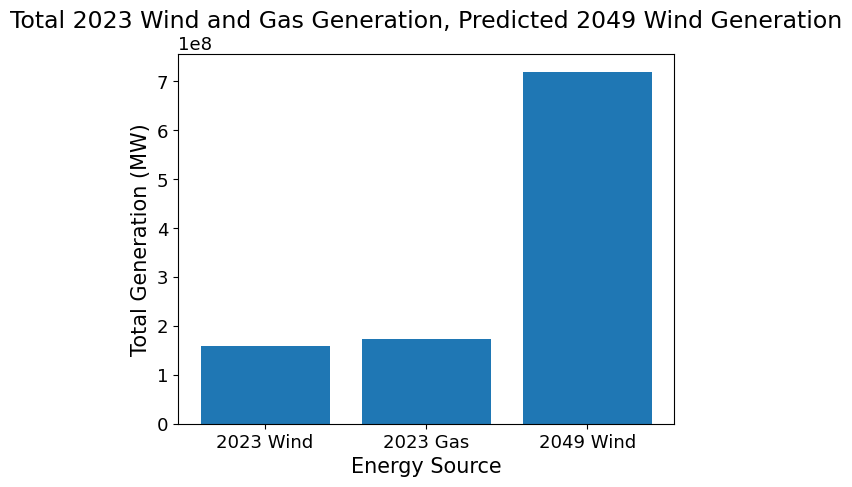

In [86]:
wind_2023 = g_monthly_pred['WINDcurr_fcast']['2023'].sum()
gas_2023 = g_monthly_pred['GAS']['2023'].sum()
wind_2049 = g_monthly_pred['WINDcurr_fcast']['2049'].sum()

plt.bar(['2023 Wind', '2023 Gas', '2049 Wind'], [wind_2023, gas_2023, wind_2049])
plt.title('Total 2023 Wind and Gas Generation, Predicted 2049 Wind Generation')
plt.ylabel('Total Generation (MW)')
plt.xlabel('Energy Source')
plt.show()

It looks as if the predicted Wind generation in 2049 is more than twice that of current Gas generation. 
We can do a simple calculation to check those values. 

Additionally, we can divide the total by 2 to get MWh (rather than purely MW). Since the dataset was originally in half-hour records of energy generation, we would need to divide by two to get hourly generation.

In [87]:
#calculation
wind_diff_mwh = (wind_2049 - (gas_2023*2))/2
wind_diff_mwh

187048632.11090153

In [88]:
wind_2049_twh = (wind_2049/2)/1000000
wind_2049_twh

359.98645511090155

Based on these simple calculations, the answer to the question is: Yes, the model does predict that UK Wind energy generation in 2049 would be MORE than twice what it is today, and the total amount of Wind energy generated would be more than twice the total Gas generation in 2023. 

In addition to the obvious caveats that these are simply estimates (ie, predicted values that have not yet fully incorporated the multitude of other external factors yet to be considered for modelling), what are the broader implications if these numbers were to be close to what a future energy generation scenario might look like? 

Where do these levels of Wind energy generation sit in the broader context of where the UK government currently estimates the country's energy demands will be?

**Will the UK have the renewable energy generation capacity to meet the country's energy needs and achieve net zero by 2050?**

According to the <a href="https://www.theccc.org.uk/wp-content/uploads/2020/12/Sector-summary-Electricity-generation.pdf">Climate Change Committee</a> (CCC, an independent non-departmental public body, formed under the Climate Change Act to advise the United Kingdom), the UK will need in the range of 550 to 680 TWh of energy in 2050. 

In commentary from the <a href="https://www.lse.ac.uk/granthaminstitute/news/costs-and-benefits-of-the-uk-reaching-net-zero-emissions-by-2050-the-evidence/">London School of Economics</a> in August 2023, the CCC estimated the cost per annum of reaching net zero in 2050 to be approximately £50.7 billion. A portion of would be offset by net operating savings that would offset investment costs.

Given the forecasted 2049 total Wind energy generation of 359,986,455 MWh (360 TWh), how would this compare to the UK's estimated energy demands and what are the associated operational costs?

According to <a href="https://ore.catapult.org.uk/blog/uk-offshore-wind-2023-round-up-and-2024-outlook/">Catapult Offshore Wind Energy</a>, the maximum striking price for offshore wind energy was adjusted to £176/MWh for March 2024.

In [89]:
#calculating operational costs of wind energy generation
wind_opex = 176

wind_2049_mwh = wind_2049/2

wind_cost_mwh_b = (wind_2049_mwh * wind_opex)/1000000000

wind_cost_mwh_b

63.35761609951867

However, Wind is not the only type of energy generated by the UK. What was the UK's total energy generation in 2023, excluding Wind?

In [90]:

#calculating TWh of energy generated in the UK in 2023, excluding Wind
energy_excl_wind_2023 = g_monthly_pred.loc['2023', g_monthly_pred.columns.difference(['WINDcurr_fcast', 'RENEWABLE', 'FOSSIL', 'population', 'GENERATIONcurr_fcast'])].sum()
energy_excl_wind_2023_sum = g_monthly_pred.loc['2023', g_monthly_pred.columns.difference(['WINDcurr_fcast', 'RENEWABLE', 'FOSSIL', 'population', 'GENERATIONcurr_fcast'])].sum().sum()
energy_exw_2023twh = (energy_excl_wind_2023_sum/2)/1000000
energy_exw_2023twh

192.444877

In [91]:
#calculate MWh for each of the non-wind energy sources, convert to dataframe
energy_excl_wind_2023_mwh = (energy_excl_wind_2023/2).sort_values(ascending=False).reset_index()

energy_excl_wind_2023_mwh.columns = ['Energy Sources', 'Generation (MWh)']

#save to .csv for use in Streamlit app
energy_excl_wind_2023_mwh.to_csv('energy_gen_2023_excl_wind.csv', index=False)

energy_excl_wind_2023_mwh

,Energy Sources,Generation (MWh)
0,GAS,86468911.5
1,NUCLEAR,38297930.0
2,IMPORTS,33426806.0
3,BIOMASS,13358736.0
4,SOLAR,13223555.5
5,HYDRO,3248055.5
6,COAL,2763254.5
7,STORAGE,1657628.0


What would our earlier plot, "2023 Generation by Energy Source (MW)", look like without Wind generation? How much energy is currently being generated from other sources in the UK?

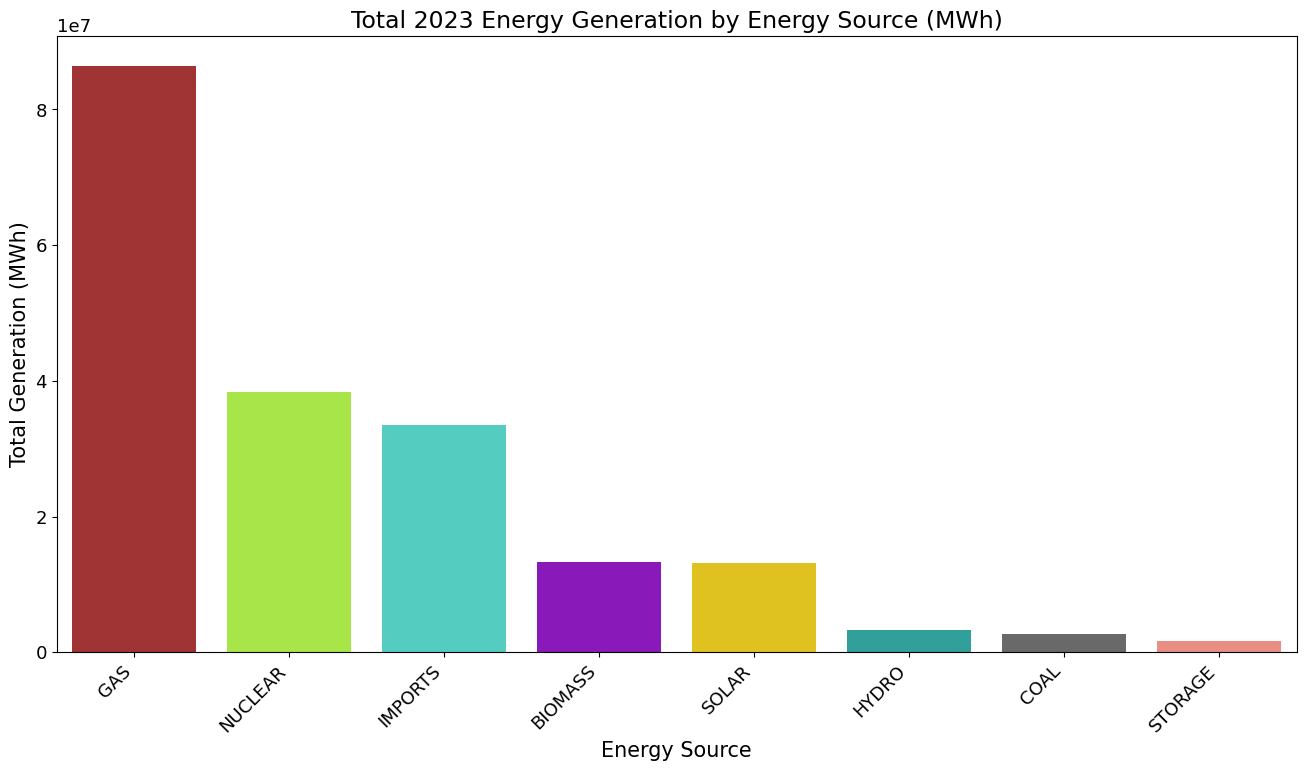

In [92]:
colors = {'GAS': 'firebrick', 'COAL': 'dimgray', 'HYDRO': 'lightseagreen', 'SOLAR': 'gold',  
          'NUCLEAR': 'greenyellow', 'BIOMASS': 'darkviolet', 'IMPORTS':'turquoise', 'STORAGE': 'salmon'}

plt.figure(figsize=(16,8))
sns.barplot(x='Energy Sources', y='Generation (MWh)', data=energy_excl_wind_2023_mwh, palette=colors)
plt.title('Total 2023 Energy Generation by Energy Source (MWh)')
plt.ylabel('Total Generation (MWh)')
plt.xlabel('Energy Source')
plt.xticks(rotation=45, ha='right')
plt.savefig('2023_gen_by_source_excl_wind.png', dpi=300)

In [94]:
#calculating the total non-wind energy generation in 2023 and the forecasted Wind energy generation in 2049
energy_2049twh = wind_2049_twh + energy_exw_2023twh

print(f'Non-Wind Energy Generation in 2023: {round(energy_exw_2023twh,0)} TWh')
print(f'Wind Energy Generation 2049: {round(wind_2049_twh,0)} TWh')
print(f'Total: 2023 Non-Wind + Wind 2049 Energy Generation: {round(energy_2049twh,0)} TWh')

Non-Wind Energy Generation in 2023: 192.0 TWh
Wind Energy Generation 2049: 360.0 TWh
Total: 2023 Non-Wind + Wind 2049 Energy Generation: 552.0 TWh


In 2023, energy generation from excluding Wind totalled 192 TWh. Added to the 360 TWh of forecasted Wind energy in 2049, the total, 552 TWh, is close to the lower range of 550TWh estimated to be the UK's total energy demand by 2050. 

The predicted Wind energy generation operational cost of £63.4 billion is slightly higher than the costs estimated by the CCC. Also important are the associated capital expenditures required to construct the wind turbines and connect them to the National Grid. Another major caveat is, we do not yet have a clear way to calculate the balance of wind energy generation costs against the cost offsets (ie, the net benefits once avoided climate change impacts and the co-benefits of net zero policies are taken into account). 

If the many hours of desktop research, combined with time series analysis forecasting conducted, has shown us anything, it is that estimating future energy generation is an incredibly complex question to answer. Many of the UK's greatest data scientists and energy experts have modelled energy forecasts on a significantly more complex level than shown in these three notebooks, encompassing many, many other factors which were not included in these calculations or could, quite possibly, be comprehended in their entirety in such a short space of time. 

For those who have found this topic equally fascinating and would like to explore in further detail the work of many combined great minds, additional sources are listed below: 

<a href="https://www.gov.uk/government/publications/net-zero-society-scenarios-and-pathways--2/net-zero-society-scenarios-and-pathways-report-html">UK Government Office for Science: net zero society report</a>

<a href="https://www.nationalgrideso.com/future-energy/future-energy-scenarios-fes">National Grid ESO: future energy scenarios</a>

<a href="https://www.theccc.org.uk/publication/climate-policy-that-cuts-costs-international-policy-comparison-energy-saving-trust-green-alliance/">CCC: international policy comparison</a>


In summary: there is hope. 

The estimate above of 552 TWh of forecasted energy generation assumes all non-wind energy generation stays static, neither growing nor shrinking, from 2023 to 2050. Given the UK's recent efforts to <a href="https://www.renewableuk.com/news/660775/Pipeline-of-UK-energy-storage-projects-grows-by-two-thirds-over-last-12-months.htm">increase availability of battery storage</a>, as well as remaining potential to <a href="https://solarenergyuk.org/resource/solars-role-in-addressing-the-energy-crisis-path-to-2023-2030-2050/">grow solar</a> and <a href="https://www.nsenergybusiness.com/features/new-assessments-reveal-uks-hydropower-capacity-and-push-for-tidal-energy/">hydro energy output</a>, there is hope for the UK to achieve net zero by 2050. There is much, much work left to be done, but there is hope.


## **SUMMARY**

### Next Steps

There is lots more to explore and model, including:

- finding other publicly available data for including additional exogenous variables in the SARIMAX model and refining it (eg, weather patterns)

- applying the model to forecasting energy generation values for other renewable energies, such as Solar and Hydro (and/or Nuclear-- <a href="https://www.world-nuclear-news.org/Articles/EDF-announces-Hinkley-Point-C-delay-and-big-rise-i">Will construction on the Hinkley Point C nuclear power plant ever reach completion?</a>)

-  researching capital expenditure costs associated with expansion of various renewable energy sources, and incorporating them into the forecasts

-  updating the dataset as additional months of recent generation data become available from National Grid ESO

### Conclusions

- XGBoost, while a better-performing model on the surface, has limitations for time series analysis, including requiring feature engineering to account for temporal dynamics, lacking the ability to account for exogenous factors, and greater risk of compounding errors when forecasting values. For these reasons, the SARIMA/SARIMAX model was chosen to predict future energy generation values to 2049.

- although it requires more effort, fitting the SARIMA model manually allows for optimising based on strength of predictors in the model, rather than using GridSearchCV and focusing on lowest AIC score (ie, there is not a direct connection between lowest AIC score and lower p-values).

- while the SARIMA model performed well on predicting overall energy generation, it had difficulty capturing the volatility of Wind values in the Test set. However, this could mean the model is more reliable in predicting stable, long-term generation values

- model reliability becomes weakther the farther into the future the values are predicted. During modelling of total energy generation, the models showed limitations due to existing trends in the data (ie, predicted values in 2049 equated to negative energy generation). One way of counterbalancing this is to model multiple  columns in the dataset (ie, modelling individual energy sources), to incorporate multiple trends and seasonality patterns into forecasted values

- based on the results of the predicted values for Wind generation, there is the potential for the UK to fulfill its energy demand needs via renewable energy sources and achieve net zero by 2050

- forecasting total energy generation for the UK (or any country) is a hugely complex, gargantuan task. These notebooks are single person's attempt to replicate some of the many year's of work completed by  thousands of experts carried on throughout the UK. It is a vast and fascinating topic worth many more hours of additional work and exploration.